In [1]:
# Importation des librairies
from netCDF4 import Dataset
import numpy as np
import os as os
from mpl_toolkits.basemap import Basemap
import matplotlib.patheffects as PathEffects
import itertools
from itertools import chain
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import pylab as p
from scipy.stats import skew, kurtosis
from matplotlib.transforms import Bbox
import sys
sys.path.insert(1, '../ERA')
from ERA_Fields import*

Model = 'Plasim'
area = 'France'
lon_start = 0
lon_end = 128
lat_start = 0 # latitudes start from 90 degrees North Pole
lat_end = 22


Months1 = [0, 0, 0, 0, 0, 0, 30, 30, 30, 30, 30, 0, 0, 0] 
Tot_Mon1 = list(itertools.accumulate(Months1))

t2m = Plasim_Field('tas','ANO_LONG_tas','Temperature', Model, lat_start, lat_end, lon_start, lon_end,'single','')
zg500 = Plasim_Field('zg','ANO_LONG_zg500','500 mbar Geopotential', Model, lat_start, lat_end, lon_start, lon_end,'single','')
zg850 = Plasim_Field('zg','ANO_LONG_zg850','850 mbar Geopotential', Model, lat_start, lat_end, lon_start, lon_end,'single','')
t2m.years=8000
zg500.years=8000
zg850.years=8000
address = '/local/gmiloshe/PLASIM/Data_Plasim_LONG/'
#address = '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/PLASIM/Data_Plasim_LONG/'
t2m.load_field(address)
zg500.load_field(address)
zg850.load_field(address)
LON = t2m.LON
LAT = t2m.LAT

Trying to import basemap
Successfully imported basemap
Loading field tas
Loaded time array
input self.var.shape = (1200000, 22, 128)
output self.var.shape = (8000, 150, 22, 128)
self.time.shape = (8000, 150)
24.0 < np.diff(self.time) < 24.0
total time: (time.time() - start_time)

Loading field zg
Loaded time array
input self.var.shape = (1200000, 22, 128)
output self.var.shape = (8000, 150, 22, 128)
self.time.shape = (8000, 150)
24.0 < np.diff(self.time) < 24.0
total time: (time.time() - start_time)

Loading field zg
Loaded time array
input self.var.shape = (1200000, 22, 128)
output self.var.shape = (8000, 150, 22, 128)
self.time.shape = (8000, 150)
24.0 < np.diff(self.time) < 24.0
total time: (time.time() - start_time)



# We are going to work with the area defined below as 'France' #

In [2]:
LON_mask = create_mask(Model,area,LON)
LAT_mask = create_mask(Model,area,LAT)
# Load the land area mask
dataset = Dataset('Data_Plasim_inter/CONTROL_lsmask.nc')
lsm = dataset.variables['lsm'][0]
dataset.close()
# Load the areas of each cell
dataset = Dataset('Data_Plasim_inter/CONTROL_gparea.nc')
cell_area = dataset.variables["cell_area"][:]
dataset.close()
mask_ocean = np.array(lsm)
mask_area = np.array(create_mask(Model,area, lsm))
coords = [50, 5., 3000000, 3000000]
#ShowArea(LON_mask, LAT_mask, create_mask(Model,area,cell_area), coords)


mask = create_mask(Model,area,cell_area)*create_mask(Model,area,lsm)  
mask = mask/np.sum(np.sum(mask))  # Here I combine both grid-point area times the mask into a normalized mask
print(mask)

[[0.07659620883735004 0.07659620883735024 0.0 0.07659620883735023]
 [0.0 0.08121761209162395 0.08121761209162395 0.08121761209162387]
 [0.0 0.08564666907139229 0.08564666907139228 0.08564666907139226]
 [0.08987284333296675 0.08987284333296709 0.08987284333296704 0.0]]


This area will define masks that will be applied as filters to compute the time series. The filter depends on the area of each cell and it uses the land-sea mask

We compute the temperature and geopotential time series for France

In [3]:
t2m.abs_area_int, t2m.ano_area_int = t2m.Set_area_integral(area,mask)
zg500.abs_area_int, zg500.ano_area_int = zg500.Set_area_integral(area,mask)
mrso.abs_area_int, mrso.ano_area_int = mrso.Set_area_integral(area,mask)

file Postproc/Int_Abs__Plasim_France_ANO_tas.npy loaded
file Postproc/Int_Ano_Abs__Plasim_France_ANO_tas.npy loaded
file Postproc/Int_Abs__Plasim_France_ANO_zg500.npy loaded
file Postproc/Int_Ano_Abs__Plasim_France_ANO_zg500.npy loaded
file Postproc/Int_Abs__Plasim_France_ANO_mrso.npy loaded
file Postproc/Int_Ano_Abs__Plasim_France_ANO_mrso.npy loaded


We define A which will serve as time average window over the temperature time series

We define percent of the data which will be treated as a heatwave based on the extremes of A

In [7]:
percent = 5
T = 14
A = np.zeros((1000, Tot_Mon1[9] - Tot_Mon1[6] - 13))   # When we use convolve (running mean) there is an extra point that we can generate by displacing the window hence 13 instead of 14
convseq = np.ones(T)/T
for y in range(1000):
    A[y,:]=np.convolve(t2m.abs_area_int[y,(Tot_Mon1[6]):(Tot_Mon1[9])],  convseq, mode='valid')
    
for myfield in [t2m, zg500]: 
    nb_events = 0
    myfieldvar = myfield.var[:,Tot_Mon1[6]:Tot_Mon1[9]  - T+1,:,:].reshape(((Tot_Mon1[9] - Tot_Mon1[6] - T+1)*1000,myfield.var.shape[2],myfield.var.shape[3]))
    print(myfieldvar.shape)
    A_reshape = A.reshape((A.shape[0]*A.shape[1]))
    threshold = np.sort(A_reshape)[np.ceil(A_reshape.shape[0]*(1-percent/100)).astype('int')]
    list_extremes = list(A_reshape > threshold)
    myfield.myfieldvar_mean=np.mean(myfieldvar[list_extremes,:,:],0)
    myfield.myfieldvar_std_all=np.std(myfieldvar[:,:,:],0)
    myfield.myfieldvar_std=np.std(myfieldvar[list_extremes,:,:],0)
    nb_events = (list_extremes).count(True)
    myfield.myfieldvar_t = (lambda a, b: np.divide(a, b, out=np.zeros(a.shape), where=b != 0))(np.sqrt(nb_events) * myfield.myfieldvar_mean, myfield.myfieldvar_std)
    myfield.myfieldvar_mean_over_std = (lambda a, b: np.divide(a, b, out=np.zeros(a.shape), where=b != 0))(myfield.myfieldvar_mean, myfield.myfieldvar_std_all)
    print("threshold = ",threshold)

(77000, 22, 128)
threshold =  2.9534851025257796
(77000, 22, 128)
threshold =  2.9534851025257796


There is no reason why the A > threshold events would be isolated, in fact most occur in  a sequence because a given day may satisfy a 14 day threshold and also the next one. Below we plot the histogram which shows how consequent lengths of A > threshold times are distributed

We define a function that extracts time series via area integral from May to September, but only June to August is taken which is then flattened into 1D array containing full 1000 years

(77000,) (77000,)
(77000,) (77000,)
(77000,) (77000,)


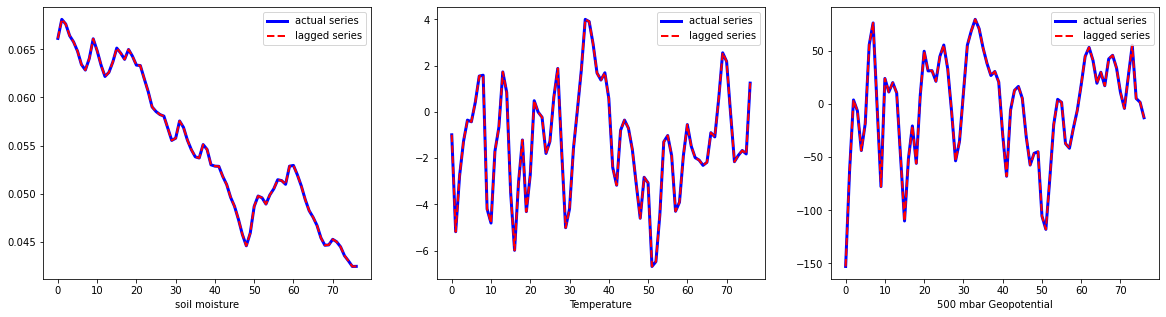

In [9]:
fig = plt.figure(figsize=(20,5))
for myfield, mysubplot in zip([mrso,t2m,zg500],[131,132,133]):
    myfield.abs_area_int_reshape = myfield.ReshapeInto1Dseries(area, mask, Tot_Mon1[6], Tot_Mon1[9], T, 0)
    print(myfield.abs_area_int_reshape.shape, A_reshape.shape)
    plt.subplot(mysubplot)
    plt.plot(myfield.abs_area_int[32,Tot_Mon1[6]:(Tot_Mon1[9] - T+1)],'b-',linewidth=3,label='actual series') # checking that the extraction of the summer series was done appropriately
    plt.plot(myfield.abs_area_int_reshape[77*32:77*33],'r--',linewidth=2,label='lagged series')
    plt.xlabel(myfield.label)
    plt.legend(loc="best")

Below we show how confusion matrix is computed

We perform logistic regression for A extrema vs soil moisture, splitting the data into 9 batches train sets and 1 batch test. This is done 10 times for cross-validation which allows us to compute error in estimation of MCC

i:  0  , X_train.shape =  (69300, 1) , X_test.shape =  (7700, 1)  , a =  0  , b =  7700
Y_train positives =  3587 Y_train negatives =  65713  , Y_test positives =  262  , Y_test negatives =  7438
saving Postproc/permutation_0_undersampling_10.npy
Y_train positives =  3587 Y_train negatives =  6571
MCC =  0.27336466920540925  , TP =  156  , TN =  6664  , FP =  774  , FN =  106
i:  1  , X_train.shape =  (69300, 1) , X_test.shape =  (7700, 1)  , a =  7700  , b =  15400
Y_train positives =  3427 Y_train negatives =  65873  , Y_test positives =  422  , Y_test negatives =  7278
saving Postproc/permutation_1_undersampling_10.npy
Y_train positives =  3427 Y_train negatives =  6587
MCC =  0.3774696390839856  , TP =  285  , TN =  6510  , FP =  768  , FN =  137
i:  2  , X_train.shape =  (69300, 1) , X_test.shape =  (7700, 1)  , a =  15400  , b =  23100
Y_train positives =  3460 Y_train negatives =  65840  , Y_test positives =  389  , Y_test negatives =  7311
saving Postproc/permutation_2_undersam

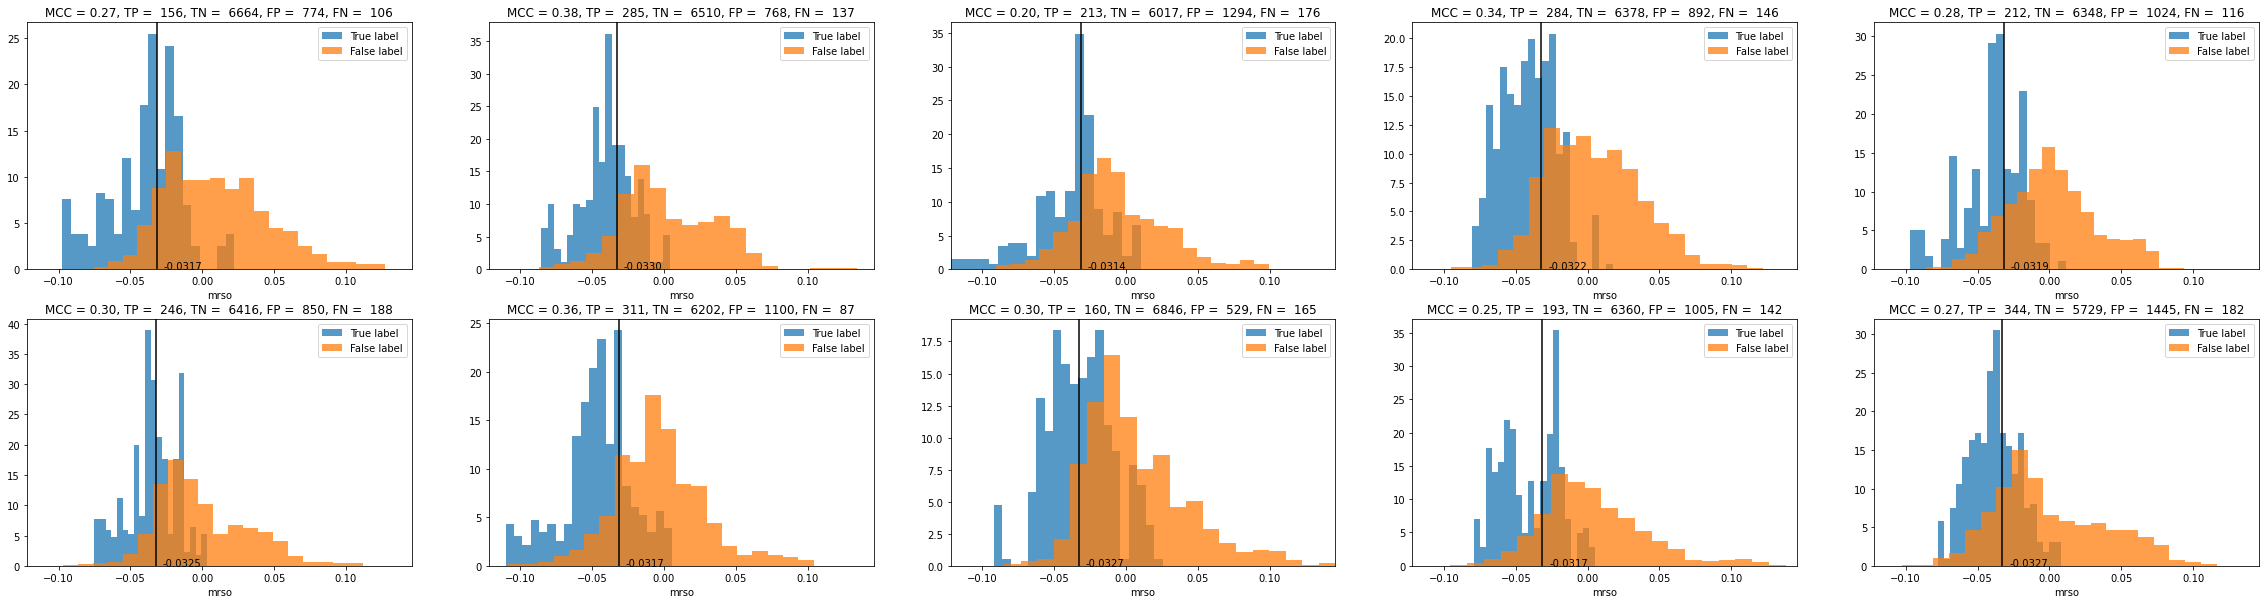

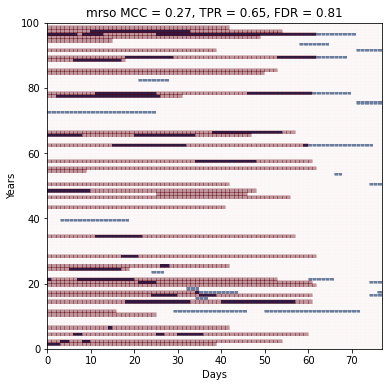

In [10]:
X = mrso.abs_area_int_reshape[:,np.newaxis]
Xname = 'mrso'
undersampling_factor = 10
labels = list_extremes
fig2 = plt.figure(figsize=(40, 10))
spec2 = gridspec.GridSpec(ncols=5, nrows=2, figure=fig2)
Tot_MCC = np.zeros(10,)
for j in range(2):
    for k in range(5):
        i = 5*j + k
        X_test, X_train, Y_test, Y_train, logreg, Y_pred, TP, TN, FP, FN, Tot_MCC[i] = SingleLogisticRegression(i,X, labels, undersampling_factor,True)
        ax = fig2.add_subplot(spec2[j, k])
        PlotLogisticRegression(X,Xname,logreg,ax, X_test, Y_test, TP, TN, FP, FN, Tot_MCC[i])
fig2.savefig("Images_Linear/logistic_regr_mrso_batch10.png", bbox_inches=full_extent(ax,.04).transformed(fig2.dpi_scale_trans.inverted()))
print("Total MCC = ", np.mean(Tot_MCC), " +- ", np.std(Tot_MCC))
fig = plt.figure(figsize=(6,6))
plt.pcolormesh(np.array(Y_test).reshape(100,-1), cmap=plt.cm.Blues)
plt.pcolormesh(np.array(logreg.predict(X_test)).reshape(100,-1), cmap=plt.cm.Reds,alpha=0.4)
plt.title(Xname+f' MCC = {Tot_MCC[9]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}')
plt.xlabel('Days')
plt.ylabel('Years')
fig.savefig("Images_Linear/batch10_"+Xname+".png")

In [1]:
undersampling_factor

NameError: name 'undersampling_factor' is not defined

In [53]:
X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, undersampling_factor,True)# Split the data into training/testing sets
#X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, 1,True)# Split the data into training/testing sets
print(f'{type(X_train)= }, {type(X_test) = }, {type(Y_train) = }, {type(Y_test) = }, {type(X_train_new) = }, {type(Y_train_new) = }')
print(f'{X_train.shape = }, {X_test.shape = }, {len(Y_train) = }, {len(Y_test) = }, {X_train_new.shape = }, {len(Y_train_new) = }')

logreg = LogisticRegression(solver='sag',C=1e5)
logreg.fit(X_train_new, Y_train_new)
Y_pred = logreg.predict(X_test) # confusion matrix works despite the fact that Y_test is True/False and Y_pred is 1/0
Y_pred_prob = logreg.predict_proba(X_test)

TP, TN, FP, FN, MCC = ComputeMCC(Y_test, Y_pred, True)

ComputeMetrics(np.array(Y_test), Y_pred_prob, 5, reundersampling_factor=undersampling_factor)    

i:  9  , X_train.shape =  (69300, 1) , X_test.shape =  (7700, 1)  , a =  69300  , b =  77000
Y_train positives =  3323 Y_train negatives =  65977  , Y_test positives =  526  , Y_test negatives =  7174
loading Postproc/permutation_9_undersampling_10.npy
Y_train positives =  3323 Y_train negatives =  6597
type(X_train)= <class 'numpy.ndarray'>, type(X_test) = <class 'numpy.ndarray'>, type(Y_train) = <class 'list'>, type(Y_test) = <class 'list'>, type(X_train_new) = <class 'numpy.ndarray'>, type(Y_train_new) = <class 'list'>
X_train.shape = (69300, 1), X_test.shape = (7700, 1), len(Y_train) = 69300, len(Y_test) = 7700, X_train_new.shape = (9920, 1), len(Y_train_new) = 9920
MCC =  0.272754864109756  , TP =  340  , TN =  5778  , FP =  1396  , FN =  186
MCC =  0.043532851462153806  , TP =  15  , TN =  7101  , FP =  73  , FN =  511
renorm =  10 , MCC =  0.043532851462153806  ,entropy =  0.21482179471696303  ,entropy =  0.21482179471696303  , skill =  -0.08214256545871179  ,BS =  0.06207192160

(0.043532851462153806,
 0.21482179471696303,
 -0.08214256545871179,
 0.062071921608664773,
 0.42677762678483294,
 0.011428571428571429)

Here we attempt to use current temperature as a predictor for A extrema which appears to be relatively good

Total MCC =  0.2631539508970398  +-  0.022679070503961035


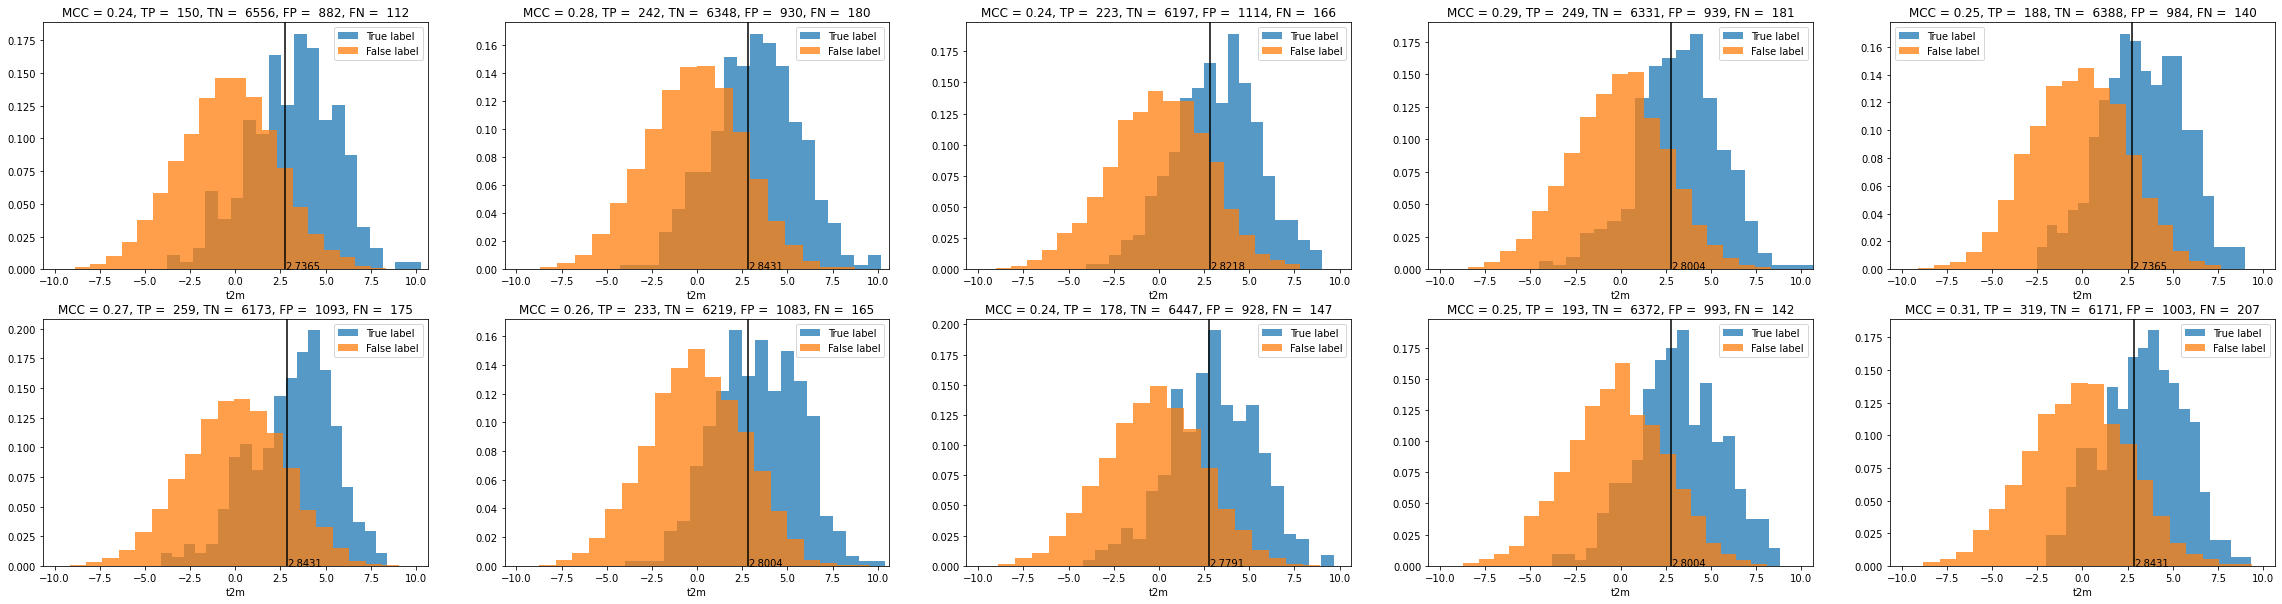

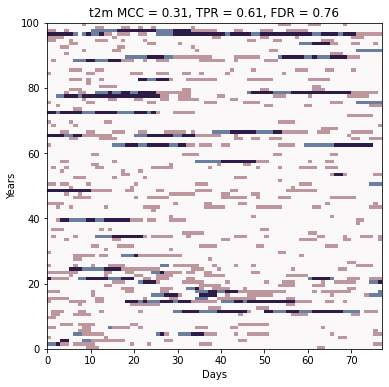

In [7]:
X = t2m.abs_area_int_reshape[:,np.newaxis]
Xname = 't2m'
undersampling_factor = 10
labels = list_extremes
fig2 = plt.figure(figsize=(40, 10))
spec2 = gridspec.GridSpec(ncols=5, nrows=2, figure=fig2)
Tot_MCC = np.zeros(10,)
for j in range(2):
    for k in range(5):
        i = 5*j + k
        X_test, X_train, Y_test, Y_train, logreg, Y_pred, TP, TN, FP, FN, Tot_MCC[i] = SingleLogisticRegression(i,X, labels, undersampling_factor,False)
        ax = fig2.add_subplot(spec2[j, k])
        PlotLogisticRegression(X,Xname,logreg,ax,X_test, Y_test, TP, TN, FP, FN, Tot_MCC[i])
print("Total MCC = ", np.mean(Tot_MCC), " +- ", np.std(Tot_MCC))
fig = plt.figure(figsize=(6,6))
plt.pcolormesh(np.array(Y_test).reshape(100,-1), cmap=plt.cm.Blues)
plt.pcolormesh(np.array(logreg.predict(X_test)).reshape(100,-1), cmap=plt.cm.Reds,alpha=0.4)
plt.title(Xname+f' MCC = {Tot_MCC[9]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}')
plt.xlabel('Days')
plt.ylabel('Years')
fig.savefig("Images_Linear/batch10_"+Xname+".png")

So both soil moisture and current temperature can be coupled to increase the separatbility of the data. Logistic regression is performed exactly the same way but now there are two dependent variables

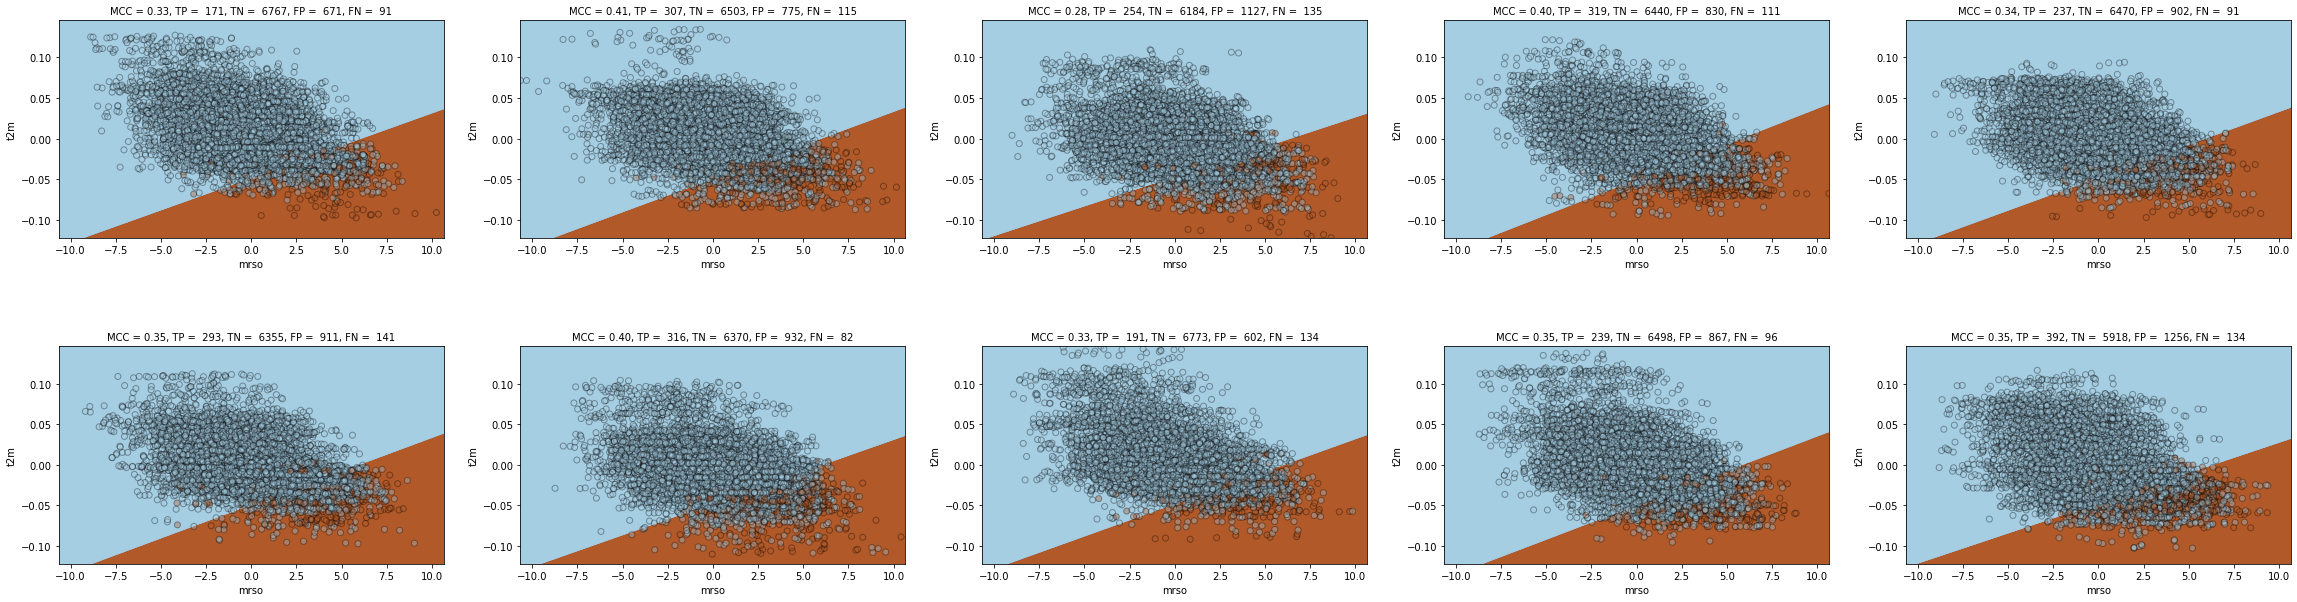

MCC =  0.35454979917498586  +-  0.03691653435165387


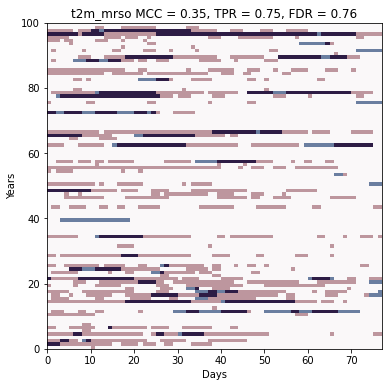

In [8]:
fig2 = plt.figure(figsize=(40, 10))
spec2 = gridspec.GridSpec(ncols=5, nrows=2, figure=fig2)
X = np.c_[t2m.abs_area_int_reshape[:,np.newaxis],mrso.abs_area_int_reshape[:,np.newaxis]]
Xname = 't2m_mrso'
Xname1 = ['mrso','t2m']
undersampling_factor = 10
labels = list_extremes
Tot_MCC = np.zeros(10,)
for j in range(2):
    for k in range(5):
        i = 5*j + k
        X = np.c_[t2m.abs_area_int_reshape[:,np.newaxis],mrso.abs_area_int_reshape[:,np.newaxis]]
        X_test, X_train, Y_test, Y_train, logreg, Y_pred, TP, TN, FP, FN, Tot_MCC[i] = SingleLogisticRegression(i,X, labels, undersampling_factor,False)
        ax = fig2.add_subplot(spec2[j, k])
        Plot2DLogisticRegression(X,Xname1,logreg,ax,X_test, Y_test, TP, TN, FP, FN, Tot_MCC[i])
plt.subplots_adjust(hspace=0.5)        
plt.show()
fig2.savefig("Images/logistic_regr_"+Xname+"_batch10.png", bbox_inches=full_extent(ax,.1).transformed(fig2.dpi_scale_trans.inverted()))
print("MCC = ", np.mean(Tot_MCC), " +- ", np.std(Tot_MCC))
plt.rcParams['pcolor.shading'] ='flat'
fig = plt.figure(figsize=(6,6))
plt.pcolormesh(np.array(Y_test).reshape(100,-1), cmap=plt.cm.Blues)
plt.pcolormesh(np.array(logreg.predict(X_test)).reshape(100,-1), cmap=plt.cm.Reds,alpha=0.4)
plt.title(Xname+f' MCC = {Tot_MCC[9]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}')
plt.xlabel('Days')
plt.ylabel('Years')
fig.savefig("Images_Linear/batch10_"+Xname+".png")

Here we are using t2m and mrso setting undersampling to 1 and using internal balanced class weight 

In [9]:
X = np.c_[t2m.abs_area_int_reshape[:,np.newaxis],mrso.abs_area_int_reshape[:,np.newaxis]]
Xname = 't2m_mrso'
Xname1 = ['mrso','t2m']
undersampling_factor = 1
labels = list_extremes
Tot_MCC_test = np.zeros(10,)
Tot_MCC = np.zeros(10,)
accuracy = np.zeros(10,)
accuracy_test = np.zeros(10,)
logreg = []
for j in range(2):
    for k in range(5):
        i = 5*j + k
        X = np.c_[t2m.abs_area_int_reshape[:,np.newaxis],mrso.abs_area_int_reshape[:,np.newaxis]]
        X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, undersampling_factor,'False')# Split the data into training/testing sets
    
        logreg.append(LogisticRegression(solver='liblinear',class_weight='balanced'))

        logreg[i].fit(X_train_new, Y_train_new)
        Y_pred = logreg[i].predict(X_test) # confusion matrix works despite the fact that Y_test is True/False and Y_pred is 1/0
        TP, TN, FP, FN, Tot_MCC_test[i] = ComputeMCC(Y_train_new, logreg[i].predict(X_train_new), 'True')
        TP, TN, FP, FN, Tot_MCC[i] = ComputeMCC(Y_test, Y_pred, 'True')
        accuracy[i] = logreg[i].score(X_train_new,Y_train_new)
        accuracy_test[i] = logreg[i].score(X_test,Y_test)
        print("accuracy train = ",accuracy[i], "accuracy test = ",accuracy_test[i])
print(f"MCC = {np.mean(Tot_MCC):.3f} +- {np.std(Tot_MCC):.3f}; MCC test = {np.mean(Tot_MCC_test):.3f} +- {np.std(Tot_MCC_test):.3f}; accuracy = {np.mean(accuracy):.3f} +- {np.std(accuracy):.3f}; accuracy test = {np.mean(accuracy_test):.3f} +- {np.std(accuracy_test):.3f} ")

i:  0  , X_train.shape =  (69300, 2) , X_test.shape =  (7700, 2)  , a =  0  , b =  7700
Y_train positives =  3587 Y_train negatives =  65713  , Y_test positives =  262  , Y_test negatives =  7438
Y_train positives =  3587 Y_train negatives =  65713
MCC =  0.3237947977455062  , TP =  2992  , TN =  51989  , FP =  13724  , FN =  595
MCC =  0.28784368242785574  , TP =  202  , TN =  6248  , FP =  1190  , FN =  60
accuracy train =  0.7933766233766234 accuracy test =  0.8376623376623377
i:  1  , X_train.shape =  (69300, 2) , X_test.shape =  (7700, 2)  , a =  7700  , b =  15400
Y_train positives =  3427 Y_train negatives =  65873  , Y_test positives =  422  , Y_test negatives =  7278
Y_train positives =  3427 Y_train negatives =  65873
MCC =  0.31633406952243853  , TP =  2856  , TN =  52057  , FP =  13816  , FN =  571
MCC =  0.35812131259061075  , TP =  360  , TN =  5878  , FP =  1400  , FN =  62
accuracy train =  0.7923953823953824 accuracy test =  0.8101298701298701
i:  2  , X_train.shape = 

Here we are using t2m and mrso setting undersampling to 1 and not setting weights

In [10]:
X = np.c_[t2m.abs_area_int_reshape[:,np.newaxis],mrso.abs_area_int_reshape[:,np.newaxis]]
Xname = 't2m_mrso'
Xname1 = ['mrso','t2m']
undersampling_factor = 1
labels = list_extremes
Tot_MCC_test = np.zeros(10,)
Tot_MCC = np.zeros(10,)
accuracy = np.zeros(10,)
accuracy_test = np.zeros(10,)
logreg = []
for j in range(2):
    for k in range(5):
        i = 5*j + k
        X = np.c_[t2m.abs_area_int_reshape[:,np.newaxis],mrso.abs_area_int_reshape[:,np.newaxis]]
        X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, undersampling_factor,'False')# Split the data into training/testing sets
    
        logreg.append(LogisticRegression(solver='liblinear'))

        logreg[i].fit(X_train_new, Y_train_new)
        Y_pred = logreg[i].predict(X_test) # confusion matrix works despite the fact that Y_test is True/False and Y_pred is 1/0
        TP, TN, FP, FN, Tot_MCC_test[i] = ComputeMCC(Y_train_new, logreg[i].predict(X_train_new), 'True')
        TP, TN, FP, FN, Tot_MCC[i] = ComputeMCC(Y_test, Y_pred, 'True')
        accuracy[i] = logreg[i].score(X_train_new,Y_train_new)
        accuracy_test[i] = logreg[i].score(X_test,Y_test)
        print("accuracy train = ",accuracy[i], "accuracy test = ",accuracy_test[i])
print(f"MCC = {np.mean(Tot_MCC):.3f} +- {np.std(Tot_MCC):.3f}; MCC test = {np.mean(Tot_MCC_test):.3f} +- {np.std(Tot_MCC_test):.3f}; accuracy = {np.mean(accuracy):.3f} +- {np.std(accuracy):.3f}; accuracy test = {np.mean(accuracy_test):.3f} +- {np.std(accuracy_test):.3f} ")

i:  0  , X_train.shape =  (69300, 2) , X_test.shape =  (7700, 2)  , a =  0  , b =  7700
Y_train positives =  3587 Y_train negatives =  65713  , Y_test positives =  262  , Y_test negatives =  7438
Y_train positives =  3587 Y_train negatives =  65713
MCC =  0.17123187505347823  , TP =  237  , TN =  65491  , FP =  222  , FN =  3350
MCC =  0.2181601301284737  , TP =  22  , TN =  7424  , FP =  14  , FN =  240
accuracy train =  0.9484559884559884 accuracy test =  0.967012987012987
i:  1  , X_train.shape =  (69300, 2) , X_test.shape =  (7700, 2)  , a =  7700  , b =  15400
Y_train positives =  3427 Y_train negatives =  65873  , Y_test positives =  422  , Y_test negatives =  7278
Y_train positives =  3427 Y_train negatives =  65873
MCC =  0.16663641121717415  , TP =  212  , TN =  65676  , FP =  197  , FN =  3215
MCC =  0.17805906601259755  , TP =  29  , TN =  7253  , FP =  25  , FN =  393
accuracy train =  0.9507647907647908 accuracy test =  0.9457142857142857
i:  2  , X_train.shape =  (69300, 

Here we are using t2m and mrso setting undersampling to 5 and not setting weights

In [11]:
X = np.c_[t2m.abs_area_int_reshape[:,np.newaxis],mrso.abs_area_int_reshape[:,np.newaxis]]
Xname = 't2m_mrso'
Xname1 = ['mrso','t2m']
undersampling_factor = 5
labels = list_extremes
Tot_MCC_test = np.zeros(10,)
Tot_MCC = np.zeros(10,)
accuracy = np.zeros(10,)
accuracy_test = np.zeros(10,)
logreg = []
for j in range(2):
    for k in range(5):
        i = 5*j + k
        X = np.c_[t2m.abs_area_int_reshape[:,np.newaxis],mrso.abs_area_int_reshape[:,np.newaxis]]
        X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, undersampling_factor,'False')# Split the data into training/testing sets
    
        logreg.append(LogisticRegression(solver='liblinear'))

        logreg[i].fit(X_train_new, Y_train_new)
        Y_pred = logreg[i].predict(X_test) # confusion matrix works despite the fact that Y_test is True/False and Y_pred is 1/0
        TP, TN, FP, FN, Tot_MCC_test[i] = ComputeMCC(Y_train_new, logreg[i].predict(X_train_new), 'True')
        TP, TN, FP, FN, Tot_MCC[i] = ComputeMCC(Y_test, Y_pred, 'True')
        accuracy[i] = logreg[i].score(X_train_new,Y_train_new)
        accuracy_test[i] = logreg[i].score(X_test,Y_test)
        print("accuracy train = ",accuracy[i], "accuracy test = ",accuracy_test[i])
print(f"MCC = {np.mean(Tot_MCC):.3f} +- {np.std(Tot_MCC):.3f}; MCC test = {np.mean(Tot_MCC_test):.3f} +- {np.std(Tot_MCC_test):.3f}; accuracy = {np.mean(accuracy):.3f} +- {np.std(accuracy):.3f}; accuracy test = {np.mean(accuracy_test):.3f} +- {np.std(accuracy_test):.3f} ")

i:  0  , X_train.shape =  (69300, 2) , X_test.shape =  (7700, 2)  , a =  0  , b =  7700
Y_train positives =  3587 Y_train negatives =  65713  , Y_test positives =  262  , Y_test negatives =  7438
Y_train positives =  3587 Y_train negatives =  13142
MCC =  0.4867260758097049  , TP =  1652  , TN =  12475  , FP =  667  , FN =  1935
MCC =  0.3391675647701508  , TP =  119  , TN =  7155  , FP =  283  , FN =  143
accuracy train =  0.8444617131926595 accuracy test =  0.9446753246753247
i:  1  , X_train.shape =  (69300, 2) , X_test.shape =  (7700, 2)  , a =  7700  , b =  15400
Y_train positives =  3427 Y_train negatives =  65873  , Y_test positives =  422  , Y_test negatives =  7278
Y_train positives =  3427 Y_train negatives =  13174
MCC =  0.4895700128599786  , TP =  1553  , TN =  12566  , FP =  608  , FN =  1874
MCC =  0.38255048469425934  , TP =  201  , TN =  6938  , FP =  340  , FN =  221
accuracy train =  0.8504909342810674 accuracy test =  0.9271428571428572
i:  2  , X_train.shape =  (69

Here we take geopotential over North Atlantic and Europe and using 5 undersampling and not specifying balanced classes

In [12]:
%%time

lat_from = [5, 5] #[13]  #[10, 10, 5]   #lat_from = [5,  5]
lat_to =  [22, 22] #[17]  #[16, 16, 22]   #lat_to =   [22, 22]
lon_from = [0,  100] #[0]  #[-1, 0, 108] #lon_from = [0,  100]
lon_to =   [15, 128] #[128] #[0, 7, 120]  #lon_to =   [15, 128]


thefield = 'zg500'
solver_loss = 'hinge' # 'liblinear' #'sag' #'liblinear'
mypenalty = 'l1' #'l2'
cost = 1e-3 # 1e5 #1e6 #1e5

max_iterations = 1e4 #3e2 #5e3 # 3e2
undersampling_factor = 5

print([percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost])
def CallRegression(): # Here we specify what kind of regression we will call
    #return LogisticRegression(solver='liblinear',C=cost, max_iter=2e2)#,max_iter=1e4,C=1e5)
    #return LogisticRegression(solver=solver_loss,C=cost, penalty=mypenalty, max_iter=max_iterations)
    return linear_model.SGDClassifier(loss=solver_loss, penalty=mypenalty, alpha=cost, max_iter=1e4)
Xname = 'test'

def Grid_ReshapeInto2Dseries(myfield,time_start,time_end,lat_from,lat_to,lon_from,lon_to,T,tau):
    temp = myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].reshape((myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[0]*myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[1],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[2],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[3])) # Normal order in python is that of C (first index changes first)
    return temp.reshape((temp.shape[0],temp.shape[1]*temp.shape[2]), order='F') # Fortran order (last index changes first)

Xs = [Grid_ReshapeInto2Dseries(zg500,Tot_Mon1[6], Tot_Mon1[9],lat_from1,lat_to1,lon_from1,lon_to1,T,0) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)]
X = np.concatenate(Xs, axis=1)
print("X.shape = ", X.shape) # do the previous statement in steps so that first we get a list (I extract the necessary sizes)


labels = list_extremes
Tot_MCC_test = np.zeros(10,)
Tot_MCC = np.zeros(10,)
accuracy = np.zeros(10,)
accuracy_test = np.zeros(10,)
logreg = []
for j in range(2):
    for k in range(5):
        i = 5*j + k
        #X = zg500.var_reshaped
        #X = np.c_[Xs[0],Xs[1]]
        X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, undersampling_factor,'False')# Split the data into training/testing sets)
        logreg.append(CallRegression())
        logreg[i].fit(X_train_new, Y_train_new)
        Y_pred = logreg[i].predict(X_test) # confusion matrix works despite the fact that Y_test is True/False and Y_pred is 1/0
        TP, TN, FP, FN, Tot_MCC_test[i] = ComputeMCC(Y_train_new, logreg[i].predict(X_train_new), 'True')
        TP, TN, FP, FN, Tot_MCC[i] = ComputeMCC(Y_test, Y_pred, 'True')
        accuracy[i] = logreg[i].score(X_train_new,Y_train_new)
        accuracy_test[i] = logreg[i].score(X_test,Y_test)
        filename = 'Postproc/Model_'+Xname+'_i'+str(i)+'.sav'
        #pickle.dump([logreg[i], percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost], open(filename, 'wb'))
        print(f"MCC {Tot_MCC[i]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}")
print(f"MCC = {np.mean(Tot_MCC):.3f} +- {np.std(Tot_MCC):.3f}; MCC test = {np.mean(Tot_MCC_test):.3f} +- {np.std(Tot_MCC_test):.3f}; accuracy = {np.mean(accuracy):.3f} +- {np.std(accuracy):.3f}; accuracy test = {np.mean(accuracy_test):.3f} +- {np.std(accuracy_test):.3f} ")

[5, 14, 'Plasim', 'France', 5, [5, 5], [22, 22], [0, 100], [15, 128], 'zg500', 'hinge', 'l1', 0.001]
X.shape =  (77000, 731)
i:  0  , X_train.shape =  (69300, 731) , X_test.shape =  (7700, 731)  , a =  0  , b =  7700
Y_train positives =  3587 Y_train negatives =  65713  , Y_test positives =  262  , Y_test negatives =  7438
Y_train positives =  3587 Y_train negatives =  13142
MCC =  0.47572166516658226  , TP =  1984  , TN =  11890  , FP =  1252  , FN =  1603
MCC =  0.25906293493080224  , TP =  144  , TN =  6713  , FP =  725  , FN =  118
MCC 0.26, TPR = 0.55, FDR = 0.83
i:  1  , X_train.shape =  (69300, 731) , X_test.shape =  (7700, 731)  , a =  7700  , b =  15400
Y_train positives =  3427 Y_train negatives =  65873  , Y_test positives =  422  , Y_test negatives =  7278
Y_train positives =  3427 Y_train negatives =  13174
MCC =  0.4190304008709324  , TP =  1583  , TN =  12094  , FP =  1080  , FN =  1844
MCC =  0.18586480054919793  , TP =  144  , TN =  6615  , FP =  663  , FN =  278
MCC 0

[0, 255, 731] [22, 22] 1 2
0
(10, 17, 15) 0 255
[np.max(logregcoef),-np.min(logregcoef)] =  [138.00189577427864, 202.8851564186093]
1
(10, 17, 28) 255 731
[np.max(logregcoef),-np.min(logregcoef)] =  [60.88388138244527, 46.96643440517916]
coef_levels_max =  138.00189577427864


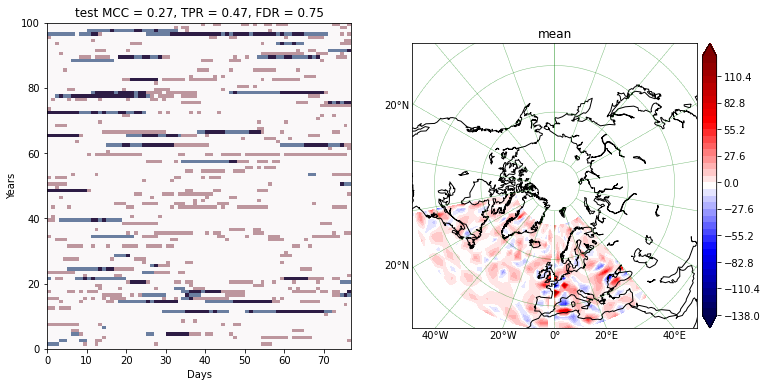

In [13]:
plt.rcParams['pcolor.shading'] ='flat'

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.pcolormesh(np.array(Y_test).reshape(100,-1), cmap=plt.cm.Blues)
plt.pcolormesh(np.array(logreg[i].predict(X_test)).reshape(100,-1), cmap=plt.cm.Reds,alpha=0.4)
plt.title(Xname+f' MCC = {Tot_MCC[9]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}')
plt.xlabel('Days')
plt.ylabel('Years')
#fig.savefig('Logistic/timelog_'+Xname+'.png')

import itertools

coef_breaks = list(itertools.accumulate([0]+[myXs.shape[1] for myXs in Xs]))
print(coef_breaks, lat_to, j, len(lat_to))
logregcoef  = []
logregcoef_std = []
logregcoef_mean_over_std = []
for j in range(len(lat_to)):
    print(j)
    logregcoef_value = np.zeros((10,lat_to[j]-lat_from[j],lon_to[j]-lon_from[j]))
    print(logregcoef_value.shape,coef_breaks[j],coef_breaks[j+1])
    for i in range(10):
        #print("logreg[i].coef_.shape = ", logreg[i].coef_.shape)
        #print("logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].shape = ", logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].shape)
        logregcoef_value[i,:,:] += logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].reshape((lat_to[j]-lat_from[j],lon_to[j]-lon_from[j]), order='F')

    logregcoef.append(np.mean(logregcoef_value,0))
    logregcoef_std.append(np.std(logregcoef_value,0))
    logregcoef_mean_over_std.append((lambda a, b: np.divide(a, b, out=np.zeros(a.shape), where=b != 0))(logregcoef[j], logregcoef_std[j]))


    print("[np.max(logregcoef),-np.min(logregcoef)] = ",[np.max(logregcoef[j]),-np.min(logregcoef[j])])

for mylogregcoef, myname in zip([logregcoef],["mean"]): #, logregcoef_std, logregcoef_mean_over_std],["mean","std","mean_over_std"]):
    ax = plt.subplot(122)
    m = Basemap(projection='nplaea',boundinglat=30,lon_0=0,resolution='c')
    npmax = 0
    npmin = 0
    coef_levels_max = np.max([np.max(mymylogregcoef) for mymylogregcoef in mylogregcoef]+[np.min(mymylogregcoef) for mymylogregcoef in mylogregcoef] ) 
    print("coef_levels_max = ", coef_levels_max)
    #coef_levels_max = np.max([np.max(mylogregcoef[0]),-np.min(mylogregcoef[0]),np.max(mylogregcoef[1]),-np.min(mylogregcoef[1])])/2
    
    if myname == "mean_over_std":
        coef_levels = np.arange(-10,10,10/20)
    else:
        coef_levels = np.arange(-coef_levels_max,coef_levels_max,(coef_levels_max/20))
    for j in range(len(lon_from)):
        m.contourf((LON[lat_from[j]:lat_to[j],lon_from[j]:lon_to[j]]), (LAT[lat_from[j]:lat_to[j],lon_from[j]:lon_to[j]]), (mylogregcoef[j]), coef_levels, cmap="seismic", extend='both', latlon=True)
    m.colorbar()
    m.drawcoastlines(color='black',linewidth=1)
    m.drawparallels(np.arange(-80.,81.,20.),linewidth=0.5,labels=[True,False,False,False], color = "green")
    m.drawmeridians(np.arange(-180.,181.,20.),linewidth=0.5,labels=[False,False,False,True],color = "green")
    plt.title(myname)
    #fig.savefig("Logistic/coef_"+myname+"_"+Xname[9:-4]+".png")

plt.show()


Here we take geopotential over North Atlantic and Europe and using 1 undersampling but specify balanced classes

In [14]:
%%time

lat_from = [5, 5] #[13]  #[10, 10, 5]   #lat_from = [5,  5]
lat_to =  [22, 22] #[17]  #[16, 16, 22]   #lat_to =   [22, 22]
lon_from = [0,  100] #[0]  #[-1, 0, 108] #lon_from = [0,  100]
lon_to =   [15, 128] #[128] #[0, 7, 120]  #lon_to =   [15, 128]


thefield = 'zg500'
solver_loss = 'hinge' # 'liblinear' #'sag' #'liblinear'
mypenalty = 'l1' #'l2'
cost = 1e-3 # 1e5 #1e6 #1e5

max_iterations = 1e4 #3e2 #5e3 # 3e2
undersampling_factor = 1

print([percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost])
def CallRegression(): # Here we specify what kind of regression we will call
    #return LogisticRegression(solver='liblinear',C=cost, max_iter=2e2)#,max_iter=1e4,C=1e5)
    #return LogisticRegression(solver=solver_loss,C=cost, penalty=mypenalty, max_iter=max_iterations)
    return linear_model.SGDClassifier(loss=solver_loss, penalty=mypenalty,class_weight='balanced', alpha=cost, max_iter=1e4)
Xname = 'test'

def Grid_ReshapeInto2Dseries(myfield,time_start,time_end,lat_from,lat_to,lon_from,lon_to,T,tau):
    temp = myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].reshape((myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[0]*myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[1],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[2],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[3])) # Normal order in python is that of C (first index changes first)
    return temp.reshape((temp.shape[0],temp.shape[1]*temp.shape[2]), order='F') # Fortran order (last index changes first)

Xs = [Grid_ReshapeInto2Dseries(zg500,Tot_Mon1[6], Tot_Mon1[9],lat_from1,lat_to1,lon_from1,lon_to1,T,0) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)]
X = np.concatenate(Xs, axis=1)
print("X.shape = ", X.shape) # do the previous statement in steps so that first we get a list (I extract the necessary sizes)


labels = list_extremes
Tot_MCC_test = np.zeros(10,)
Tot_MCC = np.zeros(10,)
accuracy = np.zeros(10,)
accuracy_test = np.zeros(10,)
logreg = []
for j in range(2):
    for k in range(5):
        i = 5*j + k
        #X = zg500.var_reshaped
        #X = np.c_[Xs[0],Xs[1]]
        X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, undersampling_factor,'False')# Split the data into training/testing sets)
        logreg.append(CallRegression())
        logreg[i].fit(X_train_new, Y_train_new)
        Y_pred = logreg[i].predict(X_test) # confusion matrix works despite the fact that Y_test is True/False and Y_pred is 1/0
        TP, TN, FP, FN, Tot_MCC_test[i] = ComputeMCC(Y_train_new, logreg[i].predict(X_train_new), 'True')
        TP, TN, FP, FN, Tot_MCC[i] = ComputeMCC(Y_test, Y_pred, 'True')
        accuracy[i] = logreg[i].score(X_train_new,Y_train_new)
        accuracy_test[i] = logreg[i].score(X_test,Y_test)
        filename = 'Postproc/Model_'+Xname+'_i'+str(i)+'.sav'
        #pickle.dump([logreg[i], percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost], open(filename, 'wb'))
        print(f"MCC {Tot_MCC[i]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}")
print(f"MCC = {np.mean(Tot_MCC):.3f} +- {np.std(Tot_MCC):.3f}; MCC test = {np.mean(Tot_MCC_test):.3f} +- {np.std(Tot_MCC_test):.3f}; accuracy = {np.mean(accuracy):.3f} +- {np.std(accuracy):.3f}; accuracy test = {np.mean(accuracy_test):.3f} +- {np.std(accuracy_test):.3f} ")

[5, 14, 'Plasim', 'France', 1, [5, 5], [22, 22], [0, 100], [15, 128], 'zg500', 'hinge', 'l1', 0.001]
X.shape =  (77000, 731)
i:  0  , X_train.shape =  (69300, 731) , X_test.shape =  (7700, 731)  , a =  0  , b =  7700
Y_train positives =  3587 Y_train negatives =  65713  , Y_test positives =  262  , Y_test negatives =  7438
Y_train positives =  3587 Y_train negatives =  65713
MCC =  0.23010105145715792  , TP =  2736  , TN =  47101  , FP =  18612  , FN =  851
MCC =  0.1820309663242574  , TP =  195  , TN =  5324  , FP =  2114  , FN =  67
MCC 0.18, TPR = 0.74, FDR = 0.92
i:  1  , X_train.shape =  (69300, 731) , X_test.shape =  (7700, 731)  , a =  7700  , b =  15400
Y_train positives =  3427 Y_train negatives =  65873  , Y_test positives =  422  , Y_test negatives =  7278
Y_train positives =  3427 Y_train negatives =  65873
MCC =  0.22248998198113684  , TP =  2817  , TN =  44076  , FP =  21797  , FN =  610
MCC =  0.20565920879499253  , TP =  323  , TN =  4857  , FP =  2421  , FN =  99
MCC 0

In [ ]:
%%time

lat_from = [5] #[13]  #[10, 10, 5]   #lat_from = [5,  5]
lat_to =  [22] #[17]  #[16, 16, 22]   #lat_to =   [22, 22]
lon_from = [0] #[0]  #[-1, 0, 108] #lon_from = [0,  100]
lon_to =   [128] #[128] #[0, 7, 120]  #lon_to =   [15, 128]


thefield = 't2m'
solver_loss = 'sag'#'hinge' # 'liblinear' #'sag' #'liblinear'
mypenalty = 'l2'#'l1' #'l2'
cost = 1e6 #1e-3 # 1e5 #1e6 #1e5

max_iterations = 5e3 #1e4 #3e2 #5e3 # 3e2
undersampling_factor = 5

print([percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost])
def CallRegression(): # Here we specify what kind of regression we will call
    #return LogisticRegression(solver='liblinear',C=cost, max_iter=2e2)#,max_iter=1e4,C=1e5)
    return LogisticRegression(solver=solver_loss,C=cost, penalty=mypenalty, max_iter=max_iterations)
    #return linear_model.SGDClassifier(loss=solver_loss, penalty=mypenalty, alpha=cost, max_iter=1e4)
Xname = 'test'

def Grid_ReshapeInto2Dseries(myfield,time_start,time_end,lat_from,lat_to,lon_from,lon_to,T,tau):
    temp = myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].reshape((myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[0]*myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[1],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[2],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[3])) # Normal order in python is that of C (first index changes first)
    return temp.reshape((temp.shape[0],temp.shape[1]*temp.shape[2]), order='F') # Fortran order (last index changes first)

Xs = [Grid_ReshapeInto2Dseries(t2m,Tot_Mon1[6], Tot_Mon1[9],lat_from1,lat_to1,lon_from1,lon_to1,T,0) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)]
X = np.concatenate(Xs, axis=1)
print("X.shape = ", X.shape) # do the previous statement in steps so that first we get a list (I extract the necessary sizes)


labels = list_extremes
Tot_MCC = np.zeros(10,)
logreg = []
for j in range(2):
    for k in range(5):
        i = 5*j + k
        #X = zg500.var_reshaped
        #X = np.c_[Xs[0],Xs[1]]
        X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, undersampling_factor,'False')# Split the data into training/testing sets)
        logreg.append(CallRegression())
        logreg[i].fit(X_train_new, Y_train_new)
        Y_pred = logreg[i].predict(X_test) # confusion matrix works despite the fact that Y_test is True/False and Y_pred is 1/0
        TP, TN, FP, FN, Tot_MCC[i] = ComputeMCC(Y_test, Y_pred, 'True')
        filename = 'Postproc/Model_'+Xname+'_i'+str(i)+'.sav'
        #pickle.dump([logreg[i], percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost], open(filename, 'wb'))
        print(f"MCC {Tot_MCC[i]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}")
print("MCC = ", np.mean(Tot_MCC), " +- ", np.std(Tot_MCC))

Here we are using t2m on a North Atlantic region using sag classifier

In [45]:
%%time

lat_from = [5, 5] #[13]  #[10, 10, 5]   #lat_from = [5,  5]
lat_to =  [22, 22] #[17]  #[16, 16, 22]   #lat_to =   [22, 22]
lon_from = [0,  100] #[0]  #[-1, 0, 108] #lon_from = [0,  100]
lon_to =   [15, 128] #[128] #[0, 7, 120]  #lon_to =   [15, 128]


thefield = 't2m'
solver_loss = 'sag'#'hinge' # 'liblinear' #'sag' #'liblinear'
mypenalty = 'l2'#'l1' #'l2'
cost = 1e6 #1e-3 # 1e5 #1e6 #1e5

max_iterations = 5e3 #1e4 #3e2 #5e3 # 3e2
undersampling_factor = 5

print([percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost])
def CallRegression(): # Here we specify what kind of regression we will call
    #return LogisticRegression(solver='liblinear',C=cost, max_iter=2e2)#,max_iter=1e4,C=1e5)
    return LogisticRegression(solver=solver_loss,C=cost, penalty=mypenalty, max_iter=max_iterations)
    #return linear_model.SGDClassifier(loss=solver_loss, penalty=mypenalty, alpha=cost, max_iter=1e4)
Xname = 'test'

def Grid_ReshapeInto2Dseries(myfield,time_start,time_end,lat_from,lat_to,lon_from,lon_to,T,tau):
    temp = myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].reshape((myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[0]*myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[1],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[2],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[3])) # Normal order in python is that of C (first index changes first)
    return temp.reshape((temp.shape[0],temp.shape[1]*temp.shape[2]), order='F') # Fortran order (last index changes first)

Xs = [Grid_ReshapeInto2Dseries(t2m,Tot_Mon1[6], Tot_Mon1[9],lat_from1,lat_to1,lon_from1,lon_to1,T,0) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)]
X = np.concatenate(Xs, axis=1)
print("X.shape = ", X.shape) # do the previous statement in steps so that first we get a list (I extract the necessary sizes)


labels = list_extremes
Tot_MCC = np.zeros(10,)
logreg = []
for j in range(2):
    for k in range(5):
        i = 5*j + k
        #X = zg500.var_reshaped
        #X = np.c_[Xs[0],Xs[1]]
        X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, undersampling_factor,'False')# Split the data into training/testing sets)
        logreg.append(CallRegression())
        logreg[i].fit(X_train_new, Y_train_new)
        Y_pred = logreg[i].predict(X_test) # confusion matrix works despite the fact that Y_test is True/False and Y_pred is 1/0
        TP, TN, FP, FN, Tot_MCC[i] = ComputeMCC(Y_test, Y_pred, 'True')
        filename = 'Postproc/Model_'+Xname+'_i'+str(i)+'.sav'
        #pickle.dump([logreg[i], percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost], open(filename, 'wb'))
        print(f"MCC {Tot_MCC[i]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}")
print("MCC = ", np.mean(Tot_MCC), " +- ", np.std(Tot_MCC))

[5, 14, 'Plasim', 'France', 5, [5, 5], [22, 22], [0, 100], [15, 128], 't2m', 'sag', 'l2', 1000000.0]
X.shape =  (77000, 731)
i:  0  , X_train.shape =  (69300, 731) , X_test.shape =  (7700, 731)  , a =  0  , b =  7700
Y_train positives =  3587 Y_train negatives =  65713  , Y_test positives =  262  , Y_test negatives =  7438
Y_train positives =  3587 Y_train negatives =  13142
MCC =  0.4104681862316487  , TP =  153  , TN =  7122  , FP =  316  , FN =  109
MCC 0.41, TPR = 0.58, FDR = 0.67
i:  1  , X_train.shape =  (69300, 731) , X_test.shape =  (7700, 731)  , a =  7700  , b =  15400
Y_train positives =  3427 Y_train negatives =  65873  , Y_test positives =  422  , Y_test negatives =  7278
Y_train positives =  3427 Y_train negatives =  13174
MCC =  0.4246774327800437  , TP =  233  , TN =  6908  , FP =  370  , FN =  189
MCC 0.42, TPR = 0.55, FDR = 0.61
i:  2  , X_train.shape =  (69300, 731) , X_test.shape =  (7700, 731)  , a =  15400  , b =  23100
Y_train positives =  3460 Y_train negatives 

[0, 255, 731] [22, 22] 1 2
0
(10, 17, 15) 0 255
[np.max(logregcoef),-np.min(logregcoef)] =  [49.81615879466779, 46.00334311134712]
1
(10, 17, 28) 255 731
[np.max(logregcoef),-np.min(logregcoef)] =  [16.809323555811552, 31.54897330883629]
coef_levels_max =  49.81615879466779


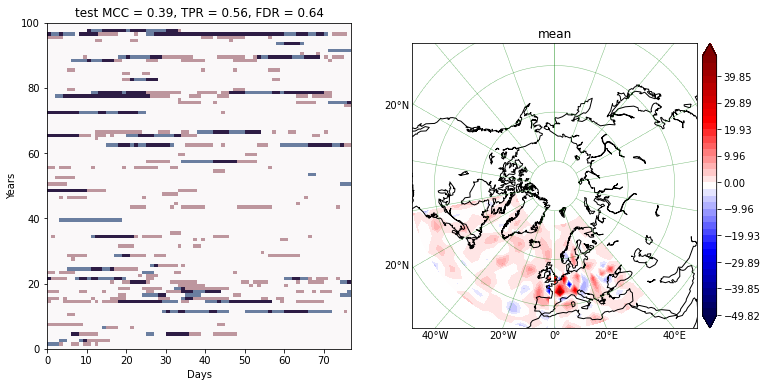

In [16]:
plt.rcParams['pcolor.shading'] ='flat'

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.pcolormesh(np.array(Y_test).reshape(100,-1), cmap=plt.cm.Blues)
plt.pcolormesh(np.array(logreg[i].predict(X_test)).reshape(100,-1), cmap=plt.cm.Reds,alpha=0.4)
plt.title(Xname+f' MCC = {Tot_MCC[9]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}')
plt.xlabel('Days')
plt.ylabel('Years')
#fig.savefig('Logistic/timelog_'+Xname+'.png')

import itertools

coef_breaks = list(itertools.accumulate([0]+[myXs.shape[1] for myXs in Xs]))
print(coef_breaks, lat_to, j, len(lat_to))
logregcoef  = []
logregcoef_std = []
logregcoef_mean_over_std = []
for j in range(len(lat_to)):
    print(j)
    logregcoef_value = np.zeros((10,lat_to[j]-lat_from[j],lon_to[j]-lon_from[j]))
    print(logregcoef_value.shape,coef_breaks[j],coef_breaks[j+1])
    for i in range(10):
        #print("logreg[i].coef_.shape = ", logreg[i].coef_.shape)
        #print("logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].shape = ", logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].shape)
        logregcoef_value[i,:,:] += logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].reshape((lat_to[j]-lat_from[j],lon_to[j]-lon_from[j]), order='F')

    logregcoef.append(np.mean(logregcoef_value,0))
    logregcoef_std.append(np.std(logregcoef_value,0))
    logregcoef_mean_over_std.append((lambda a, b: np.divide(a, b, out=np.zeros(a.shape), where=b != 0))(logregcoef[j], logregcoef_std[j]))


    print("[np.max(logregcoef),-np.min(logregcoef)] = ",[np.max(logregcoef[j]),-np.min(logregcoef[j])])

for mylogregcoef, myname in zip([logregcoef],["mean"]): #, logregcoef_std, logregcoef_mean_over_std],["mean","std","mean_over_std"]):
    ax = plt.subplot(122)
    m = Basemap(projection='nplaea',boundinglat=30,lon_0=0,resolution='c')
    npmax = 0
    npmin = 0
    coef_levels_max = np.max([np.max(mymylogregcoef) for mymylogregcoef in mylogregcoef]+[np.min(mymylogregcoef) for mymylogregcoef in mylogregcoef] ) 
    print("coef_levels_max = ", coef_levels_max)
    #coef_levels_max = np.max([np.max(mylogregcoef[0]),-np.min(mylogregcoef[0]),np.max(mylogregcoef[1]),-np.min(mylogregcoef[1])])/2
    
    if myname == "mean_over_std":
        coef_levels = np.arange(-10,10,10/20)
    else:
        coef_levels = np.arange(-coef_levels_max,coef_levels_max,(coef_levels_max/20))
    for j in range(len(lon_from)):
        m.contourf((LON[lat_from[j]:lat_to[j],lon_from[j]:lon_to[j]]), (LAT[lat_from[j]:lat_to[j],lon_from[j]:lon_to[j]]), (mylogregcoef[j]), coef_levels, cmap="seismic", extend='both', latlon=True)
    m.colorbar()
    m.drawcoastlines(color='black',linewidth=1)
    m.drawparallels(np.arange(-80.,81.,20.),linewidth=0.5,labels=[True,False,False,False], color = "green")
    m.drawmeridians(np.arange(-180.,181.,20.),linewidth=0.5,labels=[False,False,False,True],color = "green")
    plt.title(myname)
    #fig.savefig("Logistic/coef_"+myname+"_"+Xname[9:-4]+".png")

plt.show()

Here we run sag t2m on almost all north 

In [58]:
%%time

lat_from = [5] #[13]  #[10, 10, 5]   #lat_from = [5,  5]
lat_to =  [22] #[17]  #[16, 16, 22]   #lat_to =   [22, 22]
lon_from = [0] #[0]  #[-1, 0, 108] #lon_from = [0,  100]
lon_to =   [128] #[128] #[0, 7, 120]  #lon_to =   [15, 128]


thefield = 't2m'
solver_loss = 'sag'#'hinge' # 'liblinear' #'sag' #'liblinear'
mypenalty = 'l2'#'l1' #'l2'
cost = 1e6 #1e-3 # 1e5 #1e6 #1e5

max_iterations = 5e3 #1e4 #3e2 #5e3 # 3e2
undersampling_factor = 5

print([percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost])
def CallRegression(): # Here we specify what kind of regression we will call
    #return LogisticRegression(solver='liblinear',C=cost, max_iter=2e2)#,max_iter=1e4,C=1e5)
    return LogisticRegression(solver=solver_loss,C=cost, penalty=mypenalty, max_iter=max_iterations)
    #return linear_model.SGDClassifier(loss=solver_loss, penalty=mypenalty, alpha=cost, max_iter=1e4)
Xname = 'test'

def Grid_ReshapeInto2Dseries(myfield,time_start,time_end,lat_from,lat_to,lon_from,lon_to,T,tau):
    temp = myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].reshape((myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[0]*myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[1],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[2],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[3])) # Normal order in python is that of C (first index changes first)
    return temp.reshape((temp.shape[0],temp.shape[1]*temp.shape[2]), order='F') # Fortran order (last index changes first)

Xs = [Grid_ReshapeInto2Dseries(t2m,Tot_Mon1[6], Tot_Mon1[9],lat_from1,lat_to1,lon_from1,lon_to1,T,0) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)]
X = np.concatenate(Xs, axis=1)
print("X.shape = ", X.shape) # do the previous statement in steps so that first we get a list (I extract the necessary sizes)


labels = list_extremes
Tot_MCC = np.zeros(10,)
logreg = []
for j in range(2):
    for k in range(5):
        i = 5*j + k
        #X = zg500.var_reshaped
        #X = np.c_[Xs[0],Xs[1]]
        X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, undersampling_factor,'False')# Split the data into training/testing sets)
        logreg.append(CallRegression())
        logreg[i].fit(X_train_new, Y_train_new)
        Y_pred = logreg[i].predict(X_test) # confusion matrix works despite the fact that Y_test is True/False and Y_pred is 1/0
        TP, TN, FP, FN, Tot_MCC[i] = ComputeMCC(Y_test, Y_pred, 'True')
        filename = 'Postproc/Model_'+Xname+'_i'+str(i)+'.sav'
        #pickle.dump([logreg[i], percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost], open(filename, 'wb'))
        print(f"MCC {Tot_MCC[i]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}")
print("MCC = ", np.mean(Tot_MCC), " +- ", np.std(Tot_MCC))

[5, 14, 'Plasim', 'France', 5, [5], [22], [0], [128], 't2m', 'sag', 'l2', 1000000.0]
X.shape =  (77000, 2176)
i:  0  , X_train.shape =  (69300, 2176) , X_test.shape =  (7700, 2176)  , a =  0  , b =  7700
Y_train positives =  3587 Y_train negatives =  65713  , Y_test positives =  262  , Y_test negatives =  7438
Y_train positives =  3587 Y_train negatives =  13142
MCC =  0.33879171349731124  , TP =  127  , TN =  7110  , FP =  328  , FN =  135
MCC 0.34, TPR = 0.48, FDR = 0.72
i:  1  , X_train.shape =  (69300, 2176) , X_test.shape =  (7700, 2176)  , a =  7700  , b =  15400
Y_train positives =  3427 Y_train negatives =  65873  , Y_test positives =  422  , Y_test negatives =  7278
Y_train positives =  3427 Y_train negatives =  13174
MCC =  0.42067892003871865  , TP =  238  , TN =  6879  , FP =  399  , FN =  184
MCC 0.42, TPR = 0.56, FDR = 0.63
i:  2  , X_train.shape =  (69300, 2176) , X_test.shape =  (7700, 2176)  , a =  15400  , b =  23100
Y_train positives =  3460 Y_train negatives =  6584

Here we want to see if we can predict the heatwaves with the lag of 1 day. In other words, tau is set to -1. We don't change the label space.

In [47]:
%%time

lat_from = [5, 5] #[13]  #[10, 10, 5]   #lat_from = [5,  5]
lat_to =  [22, 22] #[17]  #[16, 16, 22]   #lat_to =   [22, 22]
lon_from = [0,  100] #[0]  #[-1, 0, 108] #lon_from = [0,  100]
lon_to =   [15, 128] #[128] #[0, 7, 120]  #lon_to =   [15, 128]


thefield = 't2m'
solver_loss = 'sag'#'hinge' # 'liblinear' #'sag' #'liblinear'
mypenalty = 'l2'#'l1' #'l2'
cost = 1e6 #1e-3 # 1e5 #1e6 #1e5

max_iterations = 5e3 #1e4 #3e2 #5e3 # 3e2
undersampling_factor = 5

print([percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost])
def CallRegression(): # Here we specify what kind of regression we will call
    #return LogisticRegression(solver='liblinear',C=cost, max_iter=2e2)#,max_iter=1e4,C=1e5)
    return LogisticRegression(solver=solver_loss,C=cost, penalty=mypenalty, max_iter=max_iterations)
    #return linear_model.SGDClassifier(loss=solver_loss, penalty=mypenalty, alpha=cost, max_iter=1e4)
Xname = 'test'

def Grid_ReshapeInto2Dseries(myfield,time_start,time_end,lat_from,lat_to,lon_from,lon_to,T,tau):
    temp = myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].reshape((myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[0]*myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[1],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[2],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[3])) # Normal order in python is that of C (first index changes first)
    return temp.reshape((temp.shape[0],temp.shape[1]*temp.shape[2]), order='F') # Fortran order (last index changes first)

Xs = [Grid_ReshapeInto2Dseries(t2m,Tot_Mon1[6], Tot_Mon1[9],lat_from1,lat_to1,lon_from1,lon_to1,T,-1) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)]
X = np.concatenate(Xs, axis=1)
print("X.shape = ", X.shape) # do the previous statement in steps so that first we get a list (I extract the necessary sizes)


labels = list_extremes
Tot_MCC = np.zeros(10,)
logreg = []
for j in range(2):
    for k in range(5):
        i = 5*j + k
        #X = zg500.var_reshaped
        #X = np.c_[Xs[0],Xs[1]]
        X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, undersampling_factor,'False')# Split the data into training/testing sets)
        logreg.append(CallRegression())
        logreg[i].fit(X_train_new, Y_train_new)
        Y_pred = logreg[i].predict(X_test) # confusion matrix works despite the fact that Y_test is True/False and Y_pred is 1/0
        TP, TN, FP, FN, Tot_MCC[i] = ComputeMCC(Y_test, Y_pred, 'True')
        filename = 'Postproc/Model_'+Xname+'_i'+str(i)+'.sav'
        #pickle.dump([logreg[i], percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost], open(filename, 'wb'))
        print(f"MCC {Tot_MCC[i]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}")
print("MCC = ", np.mean(Tot_MCC), " +- ", np.std(Tot_MCC))

[5, 14, 'Plasim', 'France', 5, [5, 5], [22, 22], [0, 100], [15, 128], 't2m', 'sag', 'l2', 1000000.0]
X.shape =  (77000, 731)
i:  0  , X_train.shape =  (69300, 731) , X_test.shape =  (7700, 731)  , a =  0  , b =  7700
Y_train positives =  3587 Y_train negatives =  65713  , Y_test positives =  262  , Y_test negatives =  7438
Y_train positives =  3587 Y_train negatives =  13142
MCC =  0.36501686455269733  , TP =  135  , TN =  7122  , FP =  316  , FN =  127
MCC 0.37, TPR = 0.52, FDR = 0.70
i:  1  , X_train.shape =  (69300, 731) , X_test.shape =  (7700, 731)  , a =  7700  , b =  15400
Y_train positives =  3427 Y_train negatives =  65873  , Y_test positives =  422  , Y_test negatives =  7278
Y_train positives =  3427 Y_train negatives =  13174
MCC =  0.40881711073701293  , TP =  235  , TN =  6862  , FP =  416  , FN =  187
MCC 0.41, TPR = 0.56, FDR = 0.64
i:  2  , X_train.shape =  (69300, 731) , X_test.shape =  (7700, 731)  , a =  15400  , b =  23100
Y_train positives =  3460 Y_train negative

Here we combine temperature and geopotential fields

In [51]:
%%time

lat_from = [5, 5] #[13]  #[10, 10, 5]   #lat_from = [5,  5]
lat_to =  [22, 22] #[17]  #[16, 16, 22]   #lat_to =   [22, 22]
lon_from = [0,  100] #[0]  #[-1, 0, 108] #lon_from = [0,  100]
lon_to =   [15, 128] #[128] #[0, 7, 120]  #lon_to =   [15, 128]


thefield = 't2m'
solver_loss = 'sag'#'hinge' # 'liblinear' #'sag' #'liblinear'
mypenalty = 'l2'#'l1' #'l2'
cost = 1e6 #1e-3 # 1e5 #1e6 #1e5

max_iterations = 5e3 #1e4 #3e2 #5e3 # 3e2
undersampling_factor = 5

print([percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost])
def CallRegression(): # Here we specify what kind of regression we will call
    #return LogisticRegression(solver='liblinear',C=cost, max_iter=2e2)#,max_iter=1e4,C=1e5)
    return LogisticRegression(solver=solver_loss,C=cost, penalty=mypenalty, max_iter=max_iterations)
    #return linear_model.SGDClassifier(loss=solver_loss, penalty=mypenalty, alpha=cost, max_iter=1e4)
Xname = 'test'

def Grid_ReshapeInto2Dseries(myfield,time_start,time_end,lat_from,lat_to,lon_from,lon_to,T,tau):
    temp = myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].reshape((myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[0]*myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[1],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[2],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[3])) # Normal order in python is that of C (first index changes first)
    return temp.reshape((temp.shape[0],temp.shape[1]*temp.shape[2]), order='F') # Fortran order (last index changes first)

Xs1 = [Grid_ReshapeInto2Dseries(zg500,Tot_Mon1[6], Tot_Mon1[9],lat_from1,lat_to1,lon_from1,lon_to1,T,0) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)]
Xs = [Grid_ReshapeInto2Dseries(t2m,Tot_Mon1[6], Tot_Mon1[9],lat_from1,lat_to1,lon_from1,lon_to1,T,0) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)]
X = np.c_[np.concatenate(Xs, axis=1),np.concatenate(Xs1, axis=1)]
print("X.shape = ", X.shape) # do the previous statement in steps so that first we get a list (I extract the necessary sizes)


labels = list_extremes
Tot_MCC = np.zeros(10,)
logreg = []
for j in range(2):
    for k in range(5):
        i = 5*j + k
        #X = zg500.var_reshaped
        #X = np.c_[Xs[0],Xs[1]]
        X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, undersampling_factor,'False')# Split the data into training/testing sets)
        logreg.append(CallRegression())
        logreg[i].fit(X_train_new, Y_train_new)
        Y_pred = logreg[i].predict(X_test) # confusion matrix works despite the fact that Y_test is True/False and Y_pred is 1/0
        TP, TN, FP, FN, Tot_MCC[i] = ComputeMCC(Y_test, Y_pred, 'True')
        filename = 'Postproc/Model_'+Xname+'_i'+str(i)+'.sav'
        #pickle.dump([logreg[i], percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost], open(filename, 'wb'))
        print(f"MCC {Tot_MCC[i]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}")
print("MCC = ", np.mean(Tot_MCC), " +- ", np.std(Tot_MCC))

[5, 14, 'Plasim', 'France', 5, [5, 5], [22, 22], [0, 100], [15, 128], 't2m', 'sag', 'l2', 1000000.0]
X.shape =  (77000, 1462)
i:  0  , X_train.shape =  (69300, 1462) , X_test.shape =  (7700, 1462)  , a =  0  , b =  7700
Y_train positives =  3587 Y_train negatives =  65713  , Y_test positives =  262  , Y_test negatives =  7438
Y_train positives =  3587 Y_train negatives =  13142
MCC =  0.3597070673746773  , TP =  210  , TN =  6579  , FP =  859  , FN =  52
MCC 0.36, TPR = 0.80, FDR = 0.80
i:  1  , X_train.shape =  (69300, 1462) , X_test.shape =  (7700, 1462)  , a =  7700  , b =  15400
Y_train positives =  3427 Y_train negatives =  65873  , Y_test positives =  422  , Y_test negatives =  7278
Y_train positives =  3427 Y_train negatives =  13174
MCC =  0.4048153293607773  , TP =  314  , TN =  6455  , FP =  823  , FN =  108
MCC 0.40, TPR = 0.74, FDR = 0.72
i:  2  , X_train.shape =  (69300, 1462) , X_test.shape =  (7700, 1462)  , a =  15400  , b =  23100
Y_train positives =  3460 Y_train nega

[0, 255, 731] [22, 22] 1 2
0
(10, 17, 15) 0 255
[np.max(logregcoef),-np.min(logregcoef)] =  [0.060780230537056924, 0.012078574299812317]
1
(10, 17, 28) 255 731
[np.max(logregcoef),-np.min(logregcoef)] =  [0.024233192764222623, 0.014395320531912148]
coef_levels_max =  0.060780230537056924
coef_breaks[-1] =  731
[731, 986, 1462] [22, 22] 1 2
0
(10, 17, 15) 731 986
[np.max(logregcoef),-np.min(logregcoef)] =  [0.0351006206125021, 0.02421695049852133]
1
(10, 17, 28) 986 1462
[np.max(logregcoef),-np.min(logregcoef)] =  [0.027198575995862485, 0.01573575916700065]
coef_levels_max =  0.0351006206125021


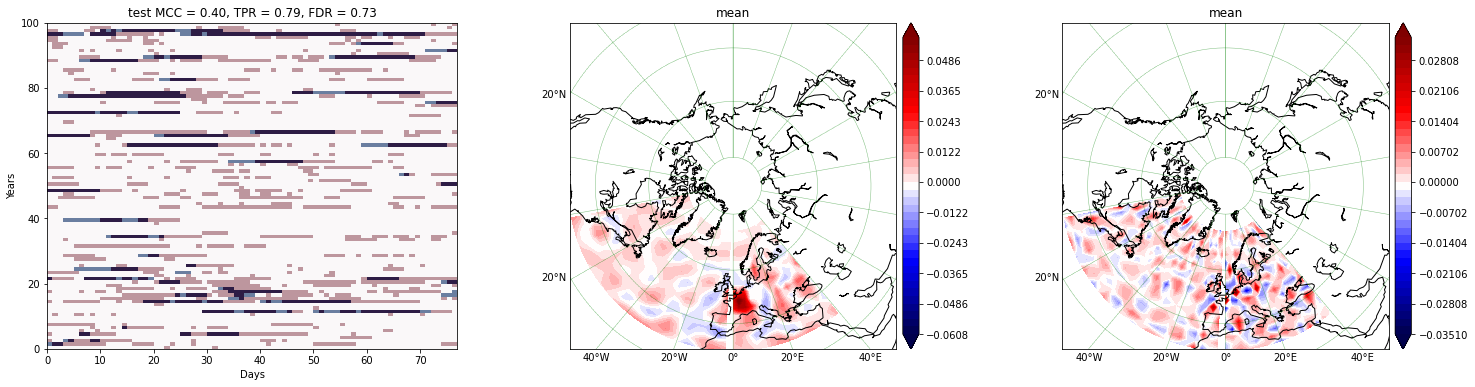

In [57]:
plt.rcParams['pcolor.shading'] ='flat'

fig = plt.figure(figsize=(25,6))
plt.subplot(131)
plt.pcolormesh(np.array(Y_test).reshape(100,-1), cmap=plt.cm.Blues)
plt.pcolormesh(np.array(logreg[i].predict(X_test)).reshape(100,-1), cmap=plt.cm.Reds,alpha=0.4)
plt.title(Xname+f' MCC = {Tot_MCC[9]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}')
plt.xlabel('Days')
plt.ylabel('Years')
#fig.savefig('Logistic/timelog_'+Xname+'.png')

import itertools

coef_breaks = list(itertools.accumulate([0]+[myXs.shape[1] for myXs in Xs]))
print(coef_breaks, lat_to, j, len(lat_to))
logregcoef  = []
logregcoef_std = []
logregcoef_mean_over_std = []
for j in range(len(lat_to)):
    print(j)
    logregcoef_value = np.zeros((10,lat_to[j]-lat_from[j],lon_to[j]-lon_from[j]))
    print(logregcoef_value.shape,coef_breaks[j],coef_breaks[j+1])
    for i in range(10):
        #print("logreg[i].coef_.shape = ", logreg[i].coef_.shape)
        #print("logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].shape = ", logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].shape)
        logregcoef_value[i,:,:] += logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].reshape((lat_to[j]-lat_from[j],lon_to[j]-lon_from[j]), order='F')

    logregcoef.append(np.mean(logregcoef_value,0))
    logregcoef_std.append(np.std(logregcoef_value,0))
    logregcoef_mean_over_std.append((lambda a, b: np.divide(a, b, out=np.zeros(a.shape), where=b != 0))(logregcoef[j], logregcoef_std[j]))


    print("[np.max(logregcoef),-np.min(logregcoef)] = ",[np.max(logregcoef[j]),-np.min(logregcoef[j])])

for mylogregcoef, myname in zip([logregcoef],["mean"]): #, logregcoef_std, logregcoef_mean_over_std],["mean","std","mean_over_std"]):
    ax = plt.subplot(132)
    m = Basemap(projection='nplaea',boundinglat=30,lon_0=0,resolution='c')
    npmax = 0
    npmin = 0
    coef_levels_max = np.max([np.max(mymylogregcoef) for mymylogregcoef in mylogregcoef]+[np.min(mymylogregcoef) for mymylogregcoef in mylogregcoef] ) 
    print("coef_levels_max = ", coef_levels_max)
    #coef_levels_max = np.max([np.max(mylogregcoef[0]),-np.min(mylogregcoef[0]),np.max(mylogregcoef[1]),-np.min(mylogregcoef[1])])/2
    
    if myname == "mean_over_std":
        coef_levels = np.arange(-10,10,10/20)
    else:
        coef_levels = np.arange(-coef_levels_max,coef_levels_max,(coef_levels_max/20))
    for j in range(len(lon_from)):
        m.contourf((LON[lat_from[j]:lat_to[j],lon_from[j]:lon_to[j]]), (LAT[lat_from[j]:lat_to[j],lon_from[j]:lon_to[j]]), (mylogregcoef[j]), coef_levels, cmap="seismic", extend='both', latlon=True)
    m.colorbar()
    m.drawcoastlines(color='black',linewidth=1)
    m.drawparallels(np.arange(-80.,81.,20.),linewidth=0.5,labels=[True,False,False,False], color = "green")
    m.drawmeridians(np.arange(-180.,181.,20.),linewidth=0.5,labels=[False,False,False,True],color = "green")
    plt.title(myname)
    #fig.savefig("Logistic/coef_"+myname+"_"+Xname[9:-4]+".png")
    
last_index = coef_breaks[-1]
print("coef_breaks[-1] = ",last_index)

    
coef_breaks = list(itertools.accumulate([last_index]+[myXs.shape[1] for myXs in Xs1]))
print(coef_breaks, lat_to, j, len(lat_to))
logregcoef  = []
logregcoef_std = []
logregcoef_mean_over_std = []
for j in range(len(lat_to)):
    print(j)
    logregcoef_value = np.zeros((10,lat_to[j]-lat_from[j],lon_to[j]-lon_from[j]))
    print(logregcoef_value.shape,coef_breaks[j],coef_breaks[j+1])
    for i in range(10):
        #print("logreg[i].coef_.shape = ", logreg[i].coef_.shape)
        #print("logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].shape = ", logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].shape)
        logregcoef_value[i,:,:] += logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].reshape((lat_to[j]-lat_from[j],lon_to[j]-lon_from[j]), order='F')

    logregcoef.append(np.mean(logregcoef_value,0))
    logregcoef_std.append(np.std(logregcoef_value,0))
    logregcoef_mean_over_std.append((lambda a, b: np.divide(a, b, out=np.zeros(a.shape), where=b != 0))(logregcoef[j], logregcoef_std[j]))


    print("[np.max(logregcoef),-np.min(logregcoef)] = ",[np.max(logregcoef[j]),-np.min(logregcoef[j])])

for mylogregcoef, myname in zip([logregcoef],["mean"]): #, logregcoef_std, logregcoef_mean_over_std],["mean","std","mean_over_std"]):
    ax = plt.subplot(133)
    m = Basemap(projection='nplaea',boundinglat=30,lon_0=0,resolution='c')
    npmax = 0
    npmin = 0
    coef_levels_max = np.max([np.max(mymylogregcoef) for mymylogregcoef in mylogregcoef]+[np.min(mymylogregcoef) for mymylogregcoef in mylogregcoef] ) 
    print("coef_levels_max = ", coef_levels_max)
    #coef_levels_max = np.max([np.max(mylogregcoef[0]),-np.min(mylogregcoef[0]),np.max(mylogregcoef[1]),-np.min(mylogregcoef[1])])/2
    
    if myname == "mean_over_std":
        coef_levels = np.arange(-10,10,10/20)
    else:
        coef_levels = np.arange(-coef_levels_max,coef_levels_max,(coef_levels_max/20))
    for j in range(len(lon_from)):
        m.contourf((LON[lat_from[j]:lat_to[j],lon_from[j]:lon_to[j]]), (LAT[lat_from[j]:lat_to[j],lon_from[j]:lon_to[j]]), (mylogregcoef[j]), coef_levels, cmap="seismic", extend='both', latlon=True)
    m.colorbar()
    m.drawcoastlines(color='black',linewidth=1)
    m.drawparallels(np.arange(-80.,81.,20.),linewidth=0.5,labels=[True,False,False,False], color = "green")
    m.drawmeridians(np.arange(-180.,181.,20.),linewidth=0.5,labels=[False,False,False,True],color = "green")
    plt.title(myname)
    #fig.savefig("Logistic/coef_"+myname+"_"+Xname[9:-4]+".png")

plt.show()

Here we are using t2m over north hemisphere region using SGD classifier

In [17]:
%%time

lat_from = [5] #[13]  #[10, 10, 5]   #lat_from = [5,  5]
lat_to =  [22] #[17]  #[16, 16, 22]   #lat_to =   [22, 22]
lon_from = [0] #[0]  #[-1, 0, 108] #lon_from = [0,  100]
lon_to =   [128] #[128] #[0, 7, 120]  #lon_to =   [15, 128]


thefield = 't2m'
solver_loss = 'hinge' # 'liblinear' #'sag' #'liblinear'
mypenalty = 'l1' #'l2'
cost = 1e-3 # 1e5 #1e6 #1e5

max_iterations = 1e4 #3e2 #5e3 # 3e2
undersampling_factor = 5

print([percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost])
def CallRegression(): # Here we specify what kind of regression we will call
    #return LogisticRegression(solver='liblinear',C=cost, max_iter=2e2)#,max_iter=1e4,C=1e5)
    #return LogisticRegression(solver=solver_loss,C=cost, penalty=mypenalty, max_iter=max_iterations)
    return linear_model.SGDClassifier(loss=solver_loss, penalty=mypenalty, alpha=cost, max_iter=1e4)
Xname = 'test'

def Grid_ReshapeInto2Dseries(myfield,time_start,time_end,lat_from,lat_to,lon_from,lon_to,T,tau):
    temp = myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].reshape((myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[0]*myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[1],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[2],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[3])) # Normal order in python is that of C (first index changes first)
    return temp.reshape((temp.shape[0],temp.shape[1]*temp.shape[2]), order='F') # Fortran order (last index changes first)

Xs = [Grid_ReshapeInto2Dseries(t2m,Tot_Mon1[6], Tot_Mon1[9],lat_from1,lat_to1,lon_from1,lon_to1,T,0) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)]

X = np.c_[mrso.abs_area_int_reshape[:,np.newaxis],np.concatenate(Xs, axis=1)]
print("X.shape = ", X.shape) # do the previous statement in steps so that first we get a list (I extract the necessary sizes)


labels = list_extremes
Tot_MCC = np.zeros(10,)
logreg = []
for j in range(2):
    for k in range(5):
        i = 5*j + k
        #X = zg500.var_reshaped
        #X = np.c_[Xs[0],Xs[1]]
        X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, undersampling_factor,'False')# Split the data into training/testing sets)
        logreg.append(CallRegression())
        logreg[i].fit(X_train_new, Y_train_new)
        Y_pred = logreg[i].predict(X_test) # confusion matrix works despite the fact that Y_test is True/False and Y_pred is 1/0
        TP, TN, FP, FN, Tot_MCC[i] = ComputeMCC(Y_test, Y_pred, 'True')
        filename = 'Postproc/Model_'+Xname+'_i'+str(i)+'.sav'
        #pickle.dump([logreg[i], percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost], open(filename, 'wb'))
        print(f"MCC {Tot_MCC[i]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}")
print("MCC = ", np.mean(Tot_MCC), " +- ", np.std(Tot_MCC))

[5, 14, 'Plasim', 'France', 5, [5], [22], [0], [128], 't2m', 'hinge', 'l1', 0.001]
X.shape =  (77000, 2177)
i:  0  , X_train.shape =  (69300, 2177) , X_test.shape =  (7700, 2177)  , a =  0  , b =  7700
Y_train positives =  3587 Y_train negatives =  65713  , Y_test positives =  262  , Y_test negatives =  7438
Y_train positives =  3587 Y_train negatives =  13142
MCC =  0.3312570011624193  , TP =  119  , TN =  7139  , FP =  299  , FN =  143
MCC 0.33, TPR = 0.45, FDR = 0.72
i:  1  , X_train.shape =  (69300, 2177) , X_test.shape =  (7700, 2177)  , a =  7700  , b =  15400
Y_train positives =  3427 Y_train negatives =  65873  , Y_test positives =  422  , Y_test negatives =  7278
Y_train positives =  3427 Y_train negatives =  13174
MCC =  0.42724206159518735  , TP =  234  , TN =  6910  , FP =  368  , FN =  188
MCC 0.43, TPR = 0.55, FDR = 0.61
i:  2  , X_train.shape =  (69300, 2177) , X_test.shape =  (7700, 2177)  , a =  15400  , b =  23100
Y_train positives =  3460 Y_train negatives =  65840  

In [18]:
%%time

lat_from = [5, 5] #[13]  #[10, 10, 5]   #lat_from = [5,  5]
lat_to =  [22, 22] #[17]  #[16, 16, 22]   #lat_to =   [22, 22]
lon_from = [0,  100] #[0]  #[-1, 0, 108] #lon_from = [0,  100]
lon_to =   [15, 128] #[128] #[0, 7, 120]  #lon_to =   [15, 128]


thefield = 'zg500_t2m'
solver_loss = 'hinge' # 'liblinear' #'sag' #'liblinear'
mypenalty = 'l1' #'l2'
cost = 1e-3 # 1e5 #1e6 #1e5

max_iterations = 2e4 #3e2 #5e3 # 3e2
undersampling_factor = 5

print([percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost])
def CallRegression(): # Here we specify what kind of regression we will call
    #return LogisticRegression(solver='liblinear',C=cost, max_iter=2e2)#,max_iter=1e4,C=1e5)
    #return LogisticRegression(solver=solver_loss,C=cost, penalty=mypenalty, max_iter=max_iterations)
    return linear_model.SGDClassifier(loss=solver_loss, penalty=mypenalty, alpha=cost, max_iter=1e4)
Xname = 'test'

def Grid_ReshapeInto2Dseries(myfield,time_start,time_end,lat_from,lat_to,lon_from,lon_to,T,tau):
    temp = myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].reshape((myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[0]*myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[1],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[2],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[3])) # Normal order in python is that of C (first index changes first)
    return temp.reshape((temp.shape[0],temp.shape[1]*temp.shape[2]), order='F') # Fortran order (last index changes first)

Xs = [Grid_ReshapeInto2Dseries(t2m,Tot_Mon1[6], Tot_Mon1[9],lat_from1,lat_to1,lon_from1,lon_to1,T,0) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)]
Xs2 = [Grid_ReshapeInto2Dseries(zg500,Tot_Mon1[6], Tot_Mon1[9],lat_from1,lat_to1,lon_from1,lon_to1,T,0) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)]

X = np.c_[np.concatenate(Xs, axis=1),np.concatenate(Xs2, axis=1)]
print("X.shape = ", X.shape) # do the previous statement in steps so that first we get a list (I extract the necessary sizes)


labels = list_extremes
Tot_MCC = np.zeros(10,)
logreg = []
for j in range(2):
    for k in range(5):
        i = 5*j + k
        #X = zg500.var_reshaped
        #X = np.c_[Xs[0],Xs[1]]
        X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, undersampling_factor,'False')# Split the data into training/testing sets)
        logreg.append(CallRegression())
        logreg[i].fit(X_train_new, Y_train_new)
        Y_pred = logreg[i].predict(X_test) # confusion matrix works despite the fact that Y_test is True/False and Y_pred is 1/0
        TP, TN, FP, FN, Tot_MCC[i] = ComputeMCC(Y_test, Y_pred, 'True')
        filename = 'Postproc/Model_'+Xname+'_i'+str(i)+'.sav'
        #pickle.dump([logreg[i], percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost], open(filename, 'wb'))
        print(f"MCC {Tot_MCC[i]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}")
print("MCC = ", np.mean(Tot_MCC), " +- ", np.std(Tot_MCC))

[5, 14, 'Plasim', 'France', 5, [5, 5], [22, 22], [0, 100], [15, 128], 'zg500_t2m', 'hinge', 'l1', 0.001]
X.shape =  (77000, 1462)
i:  0  , X_train.shape =  (69300, 1462) , X_test.shape =  (7700, 1462)  , a =  0  , b =  7700
Y_train positives =  3587 Y_train negatives =  65713  , Y_test positives =  262  , Y_test negatives =  7438
Y_train positives =  3587 Y_train negatives =  13142
MCC =  0.286882515793407  , TP =  172  , TN =  6573  , FP =  865  , FN =  90
MCC 0.29, TPR = 0.66, FDR = 0.83
i:  1  , X_train.shape =  (69300, 1462) , X_test.shape =  (7700, 1462)  , a =  7700  , b =  15400
Y_train positives =  3427 Y_train negatives =  65873  , Y_test positives =  422  , Y_test negatives =  7278
Y_train positives =  3427 Y_train negatives =  13174
MCC =  0.3371781450525484  , TP =  238  , TN =  6624  , FP =  654  , FN =  184
MCC 0.34, TPR = 0.56, FDR = 0.73
i:  2  , X_train.shape =  (69300, 1462) , X_test.shape =  (7700, 1462)  , a =  15400  , b =  23100
Y_train positives =  3460 Y_train n

In [20]:
X.shape

(77000, 1462)

In [21]:
lon_start = 0
lon_end = 128
lat_start = 0 # latitudes start from 90 degrees North Pole
lat_end = 22
t2m_2by2 = Plasim_Field('tas','ANO_tas_2by2','Temperature', Model, lat_start//2, lat_end//2, lon_start//2, lon_end//2)
zg500_2by2 = Plasim_Field('zg','ANO_zg500_2by2','500 mbar Geopotential', Model, lat_start//2, lat_end//2, lon_start//2, lon_end//2)
t2m_2by2.load_field('Data_Plasim/')
zg500_2by2.load_field('Data_Plasim/')
mrso_2by2 = Plasim_Field('mrso','ANO_mrso_2by2','soil moisture', Model, lat_start//2, lat_end//2, lon_start//2, lon_end//2)
mrso_2by2.load_field('Data_Plasim/')
LON_2by2 = t2m_2by2.LON
LAT_2by2 = t2m_2by2.LAT

input var.shape =  (150000, 11, 64)
output var.shape =  (1000, 150, 11, 64)
self.time.shape =  (1000, 150)
1.0  < np.diff(self.time) <  1.0
input var.shape =  (150000, 11, 64)
output var.shape =  (1000, 150, 11, 64)
self.time.shape =  (1000, 150)
1.0  < np.diff(self.time) <  1.0
input var.shape =  (150000, 11, 64)
output var.shape =  (1000, 150, 11, 64)
self.time.shape =  (1000, 150)
1.0  < np.diff(self.time) <  1.0


0
30
60
90
0
30
60
90


<Figure size 2880x2880 with 0 Axes>

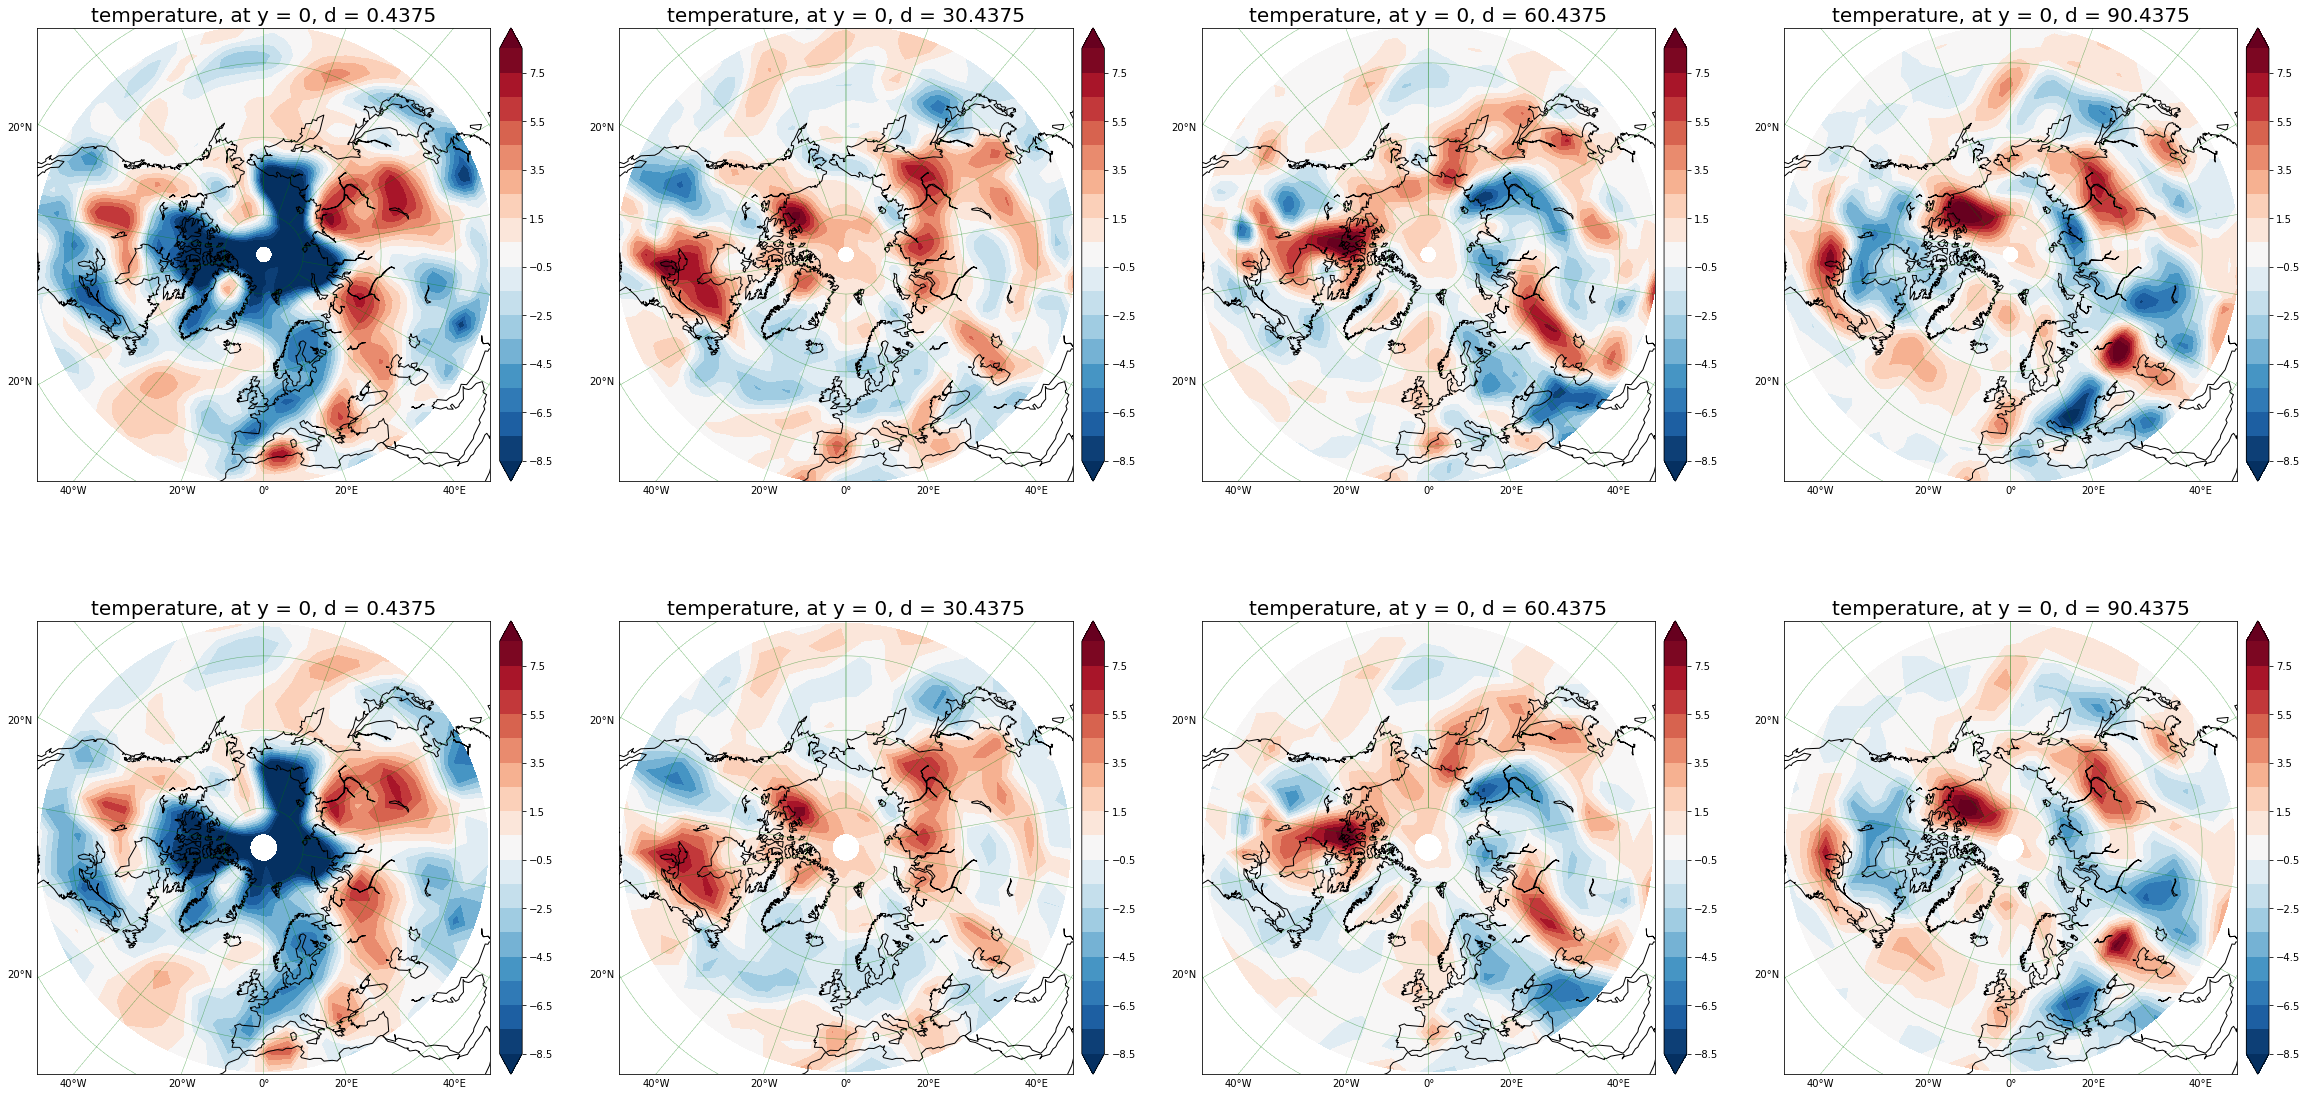

In [22]:
K = 273.15
y = 0


t2m.levels = np.linspace(-8.5, 8.5, 18)  # Levels to be used when plotting 
fig2 = plt.figure(figsize=(40, 40))
spec2 = gridspec.GridSpec(ncols=4, nrows=2, figure=fig2)
iterate = 0
ax = []
fig2 = plt.figure(figsize=(40, 20))
for i,subplt in zip(Tot_Mon1[5:9],['141','142','143','144']):
    ax.append(fig2.add_subplot(spec2[0,iterate]))
    iterate = iterate + 1
    print(i)
    m = Basemap(projection='nplaea',boundinglat=30,lon_0=0,resolution='c')
    geo_contourf(m, ax[iterate-1], 0, Greenwich(LON), Greenwich(LAT), Greenwich(t2m.var[y,i,:,:]), t2m.levels, "RdBu_r", "temperature, at y = " + str(y)+", d = "+str(t2m.time[y,i]))
iterate = 0
for i,subplt in zip(Tot_Mon1[5:9],['141','142','143','144']):    
    ax.append(fig2.add_subplot(spec2[1,iterate]))
    iterate = iterate + 1
    print(i)
    m = Basemap(projection='nplaea',boundinglat=30,lon_0=0,resolution='c')
    geo_contourf(m, ax[iterate-1], 0, Greenwich(LON_2by2), Greenwich(LAT_2by2), Greenwich(t2m_2by2.var[y,i,:,:]), t2m.levels, "RdBu_r", "temperature, at y = " + str(y)+", d = "+str(t2m.time[y,i]))

Working with 2m temperature North Atlantic coarse grained

In [23]:
%%time

lat_from = [5//2, 5//2] #[13]  #[10, 10, 5]   #lat_from = [5,  5]
lat_to =  [22//2, 22//2] #[17]  #[16, 16, 22]   #lat_to =   [22, 22]
lon_from = [0//2,  100//2] #[0]  #[-1, 0, 108] #lon_from = [0,  100]
lon_to =   [15//2, 128//2] #[128] #[0, 7, 120]  #lon_to =   [15, 128]


thefield = 't2m'
solver_loss = 'hinge' # 'liblinear' #'sag' #'liblinear'
mypenalty = 'l1' #'l2'
cost = 1e-3 # 1e5 #1e6 #1e5

max_iterations = 1e4 #3e2 #5e3 # 3e2
undersampling_factor = 5

print([percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost])
def CallRegression(): # Here we specify what kind of regression we will call
    #return LogisticRegression(solver='liblinear',C=cost, max_iter=2e2)#,max_iter=1e4,C=1e5)
    #return LogisticRegression(solver=solver_loss,C=cost, penalty=mypenalty, max_iter=max_iterations)
    return linear_model.SGDClassifier(loss=solver_loss, penalty=mypenalty, alpha=cost, max_iter=1e4)
Xname = 'test'

def Grid_ReshapeInto2Dseries(myfield,time_start,time_end,lat_from,lat_to,lon_from,lon_to,T,tau):
    temp = myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].reshape((myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[0]*myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[1],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[2],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[3])) # Normal order in python is that of C (first index changes first)
    return temp.reshape((temp.shape[0],temp.shape[1]*temp.shape[2]), order='F') # Fortran order (last index changes first)

Xs = [Grid_ReshapeInto2Dseries(t2m_2by2,Tot_Mon1[6], Tot_Mon1[9],lat_from1,lat_to1,lon_from1,lon_to1,T,0) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)]
X = np.concatenate(Xs, axis=1)
print("X.shape = ", X.shape) # do the previous statement in steps so that first we get a list (I extract the necessary sizes)


labels = list_extremes
Tot_MCC = np.zeros(10,)
logreg = []
for j in range(2):
    for k in range(5):
        i = 5*j + k
        #X = zg500.var_reshaped
        #X = np.c_[Xs[0],Xs[1]]
        X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, undersampling_factor,'False')# Split the data into training/testing sets)
        logreg.append(CallRegression())
        logreg[i].fit(X_train_new, Y_train_new)
        Y_pred = logreg[i].predict(X_test) # confusion matrix works despite the fact that Y_test is True/False and Y_pred is 1/0
        TP, TN, FP, FN, Tot_MCC[i] = ComputeMCC(Y_test, Y_pred, 'True')
        filename = 'Postproc/Model_'+Xname+'_i'+str(i)+'.sav'
        #pickle.dump([logreg[i], percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost], open(filename, 'wb'))
        print(f"MCC {Tot_MCC[i]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}")
print("MCC = ", np.mean(Tot_MCC), " +- ", np.std(Tot_MCC))

[5, 14, 'Plasim', 'France', 5, [2, 2], [11, 11], [0, 50], [7, 64], 't2m', 'hinge', 'l1', 0.001]
X.shape =  (77000, 189)
i:  0  , X_train.shape =  (69300, 189) , X_test.shape =  (7700, 189)  , a =  0  , b =  7700
Y_train positives =  3587 Y_train negatives =  65713  , Y_test positives =  262  , Y_test negatives =  7438
Y_train positives =  3587 Y_train negatives =  13142
MCC =  0.3405095242324687  , TP =  134  , TN =  7073  , FP =  365  , FN =  128
MCC 0.34, TPR = 0.51, FDR = 0.73
i:  1  , X_train.shape =  (69300, 189) , X_test.shape =  (7700, 189)  , a =  7700  , b =  15400
Y_train positives =  3427 Y_train negatives =  65873  , Y_test positives =  422  , Y_test negatives =  7278
Y_train positives =  3427 Y_train negatives =  13174
MCC =  0.42764152337519845  , TP =  230  , TN =  6926  , FP =  352  , FN =  192
MCC 0.43, TPR = 0.55, FDR = 0.60
i:  2  , X_train.shape =  (69300, 189) , X_test.shape =  (7700, 189)  , a =  15400  , b =  23100
Y_train positives =  3460 Y_train negatives =  6

In [24]:
%%time

lat_from = [5//2, 5//2] #[13]  #[10, 10, 5]   #lat_from = [5,  5]
lat_to =  [22//2, 22//2] #[17]  #[16, 16, 22]   #lat_to =   [22, 22]
lon_from = [0//2,  100//2] #[0]  #[-1, 0, 108] #lon_from = [0,  100]
lon_to =   [15//2, 128//2] #[128] #[0, 7, 120]  #lon_to =   [15, 128]


thefield = 't2m'
solver_loss = 'hinge' # 'liblinear' #'sag' #'liblinear'
mypenalty = 'l1' #'l2'
cost = 1e-3 # 1e5 #1e6 #1e5

max_iterations = 1e4 #3e2 #5e3 # 3e2
undersampling_factor = 5

print([percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost])
def CallRegression(): # Here we specify what kind of regression we will call
    #return LogisticRegression(solver='liblinear',C=cost, max_iter=2e2)#,max_iter=1e4,C=1e5)
    #return LogisticRegression(solver=solver_loss,C=cost, penalty=mypenalty, max_iter=max_iterations)
    return linear_model.SGDClassifier(loss=solver_loss, penalty=mypenalty, alpha=cost, max_iter=1e4)
Xname = 'test'

def Grid_ReshapeInto2Dseries(myfield,time_start,time_end,lat_from,lat_to,lon_from,lon_to,T,tau):
    temp = myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].reshape((myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[0]*myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[1],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[2],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[3])) # Normal order in python is that of C (first index changes first)
    return temp.reshape((temp.shape[0],temp.shape[1]*temp.shape[2]), order='F') # Fortran order (last index changes first)

Xs = [Grid_ReshapeInto2Dseries(t2m_2by2,Tot_Mon1[6], Tot_Mon1[9],lat_from1,lat_to1,lon_from1,lon_to1,T,0) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)]
X = np.concatenate(Xs, axis=1)
print("X.shape = ", X.shape) # do the previous statement in steps so that first we get a list (I extract the necessary sizes)


labels = list_extremes
Tot_MCC = np.zeros(10,)
logreg = []
for j in range(2):
    for k in range(5):
        i = 5*j + k
        #X = zg500.var_reshaped
        #X = np.c_[Xs[0],Xs[1]]
        X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, undersampling_factor,'False')# Split the data into training/testing sets)
        logreg.append(CallRegression())
        logreg[i].fit(X_train_new, Y_train_new)
        Y_pred = logreg[i].predict(X_test) # confusion matrix works despite the fact that Y_test is True/False and Y_pred is 1/0
        TP, TN, FP, FN, Tot_MCC[i] = ComputeMCC(Y_test, Y_pred, 'True')
        filename = 'Postproc/Model_'+Xname+'_i'+str(i)+'.sav'
        #pickle.dump([logreg[i], percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost], open(filename, 'wb'))
        print(f"MCC {Tot_MCC[i]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}")
print("MCC = ", np.mean(Tot_MCC), " +- ", np.std(Tot_MCC))

[5, 14, 'Plasim', 'France', 5, [2, 2], [11, 11], [0, 50], [7, 64], 't2m', 'hinge', 'l1', 0.001]
X.shape =  (77000, 189)
i:  0  , X_train.shape =  (69300, 189) , X_test.shape =  (7700, 189)  , a =  0  , b =  7700
Y_train positives =  3587 Y_train negatives =  65713  , Y_test positives =  262  , Y_test negatives =  7438
Y_train positives =  3587 Y_train negatives =  13142
MCC =  0.32273562720967064  , TP =  123  , TN =  7097  , FP =  341  , FN =  139
MCC 0.32, TPR = 0.47, FDR = 0.73
i:  1  , X_train.shape =  (69300, 189) , X_test.shape =  (7700, 189)  , a =  7700  , b =  15400
Y_train positives =  3427 Y_train negatives =  65873  , Y_test positives =  422  , Y_test negatives =  7278
Y_train positives =  3427 Y_train negatives =  13174
MCC =  0.4123902227302908  , TP =  219  , TN =  6934  , FP =  344  , FN =  203
MCC 0.41, TPR = 0.52, FDR = 0.61
i:  2  , X_train.shape =  (69300, 189) , X_test.shape =  (7700, 189)  , a =  15400  , b =  23100
Y_train positives =  3460 Y_train negatives =  6

[0, 63, 189] [11, 11] 1 2
0
(10, 9, 7) 0 63
[np.max(logregcoef),-np.min(logregcoef)] =  [12.943005148683653, 4.340896563326232]
1
(10, 9, 14) 63 189
[np.max(logregcoef),-np.min(logregcoef)] =  [7.909493649215257, 10.6579389740116]
coef_levels_max =  12.943005148683653


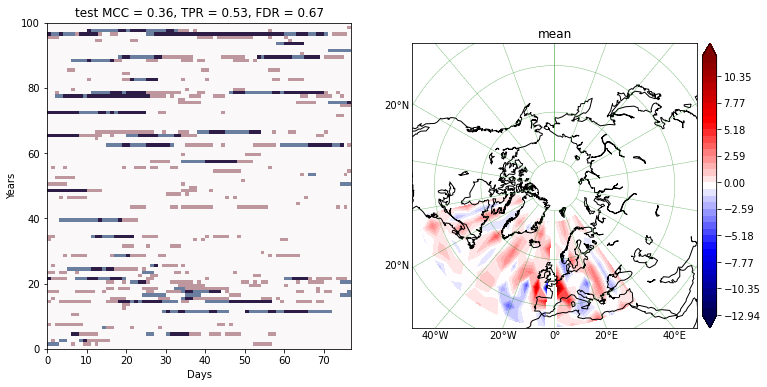

In [25]:
plt.rcParams['pcolor.shading'] ='flat'

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.pcolormesh(np.array(Y_test).reshape(100,-1), cmap=plt.cm.Blues)
plt.pcolormesh(np.array(logreg[i].predict(X_test)).reshape(100,-1), cmap=plt.cm.Reds,alpha=0.4)
plt.title(Xname+f' MCC = {Tot_MCC[9]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}')
plt.xlabel('Days')
plt.ylabel('Years')
#fig.savefig('Logistic/timelog_'+Xname+'.png')

import itertools

coef_breaks = list(itertools.accumulate([0]+[myXs.shape[1] for myXs in Xs]))
print(coef_breaks, lat_to, j, len(lat_to))
logregcoef  = []
logregcoef_std = []
logregcoef_mean_over_std = []
for j in range(len(lat_to)):
    print(j)
    logregcoef_value = np.zeros((10,lat_to[j]-lat_from[j],lon_to[j]-lon_from[j]))
    print(logregcoef_value.shape,coef_breaks[j],coef_breaks[j+1])
    for i in range(10):
        #print("logreg[i].coef_.shape = ", logreg[i].coef_.shape)
        #print("logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].shape = ", logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].shape)
        logregcoef_value[i,:,:] += logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].reshape((lat_to[j]-lat_from[j],lon_to[j]-lon_from[j]), order='F')

    logregcoef.append(np.mean(logregcoef_value,0))
    logregcoef_std.append(np.std(logregcoef_value,0))
    logregcoef_mean_over_std.append((lambda a, b: np.divide(a, b, out=np.zeros(a.shape), where=b != 0))(logregcoef[j], logregcoef_std[j]))


    print("[np.max(logregcoef),-np.min(logregcoef)] = ",[np.max(logregcoef[j]),-np.min(logregcoef[j])])

for mylogregcoef, myname in zip([logregcoef],["mean"]): #, logregcoef_std, logregcoef_mean_over_std],["mean","std","mean_over_std"]):
    ax = plt.subplot(122)
    m = Basemap(projection='nplaea',boundinglat=30,lon_0=0,resolution='c')
    npmax = 0
    npmin = 0
    coef_levels_max = np.max([np.max(mymylogregcoef) for mymylogregcoef in mylogregcoef]+[np.min(mymylogregcoef) for mymylogregcoef in mylogregcoef] ) 
    print("coef_levels_max = ", coef_levels_max)
    #coef_levels_max = np.max([np.max(mylogregcoef[0]),-np.min(mylogregcoef[0]),np.max(mylogregcoef[1]),-np.min(mylogregcoef[1])])/2
    
    if myname == "mean_over_std":
        coef_levels = np.arange(-10,10,10/20)
    else:
        coef_levels = np.arange(-coef_levels_max,coef_levels_max,(coef_levels_max/20))
    for j in range(len(lon_from)):
        m.contourf((LON_2by2[lat_from[j]:lat_to[j],lon_from[j]:lon_to[j]]), (LAT_2by2[lat_from[j]:lat_to[j],lon_from[j]:lon_to[j]]), (mylogregcoef[j]), coef_levels, cmap="seismic", extend='both', latlon=True)
    m.colorbar()
    m.drawcoastlines(color='black',linewidth=1)
    m.drawparallels(np.arange(-80.,81.,20.),linewidth=0.5,labels=[True,False,False,False], color = "green")
    m.drawmeridians(np.arange(-180.,181.,20.),linewidth=0.5,labels=[False,False,False,True],color = "green")
    plt.title(myname)
    #fig.savefig("Logistic/coef_"+myname+"_"+Xname[9:-4]+".png")

plt.show()

Working with 2m temperature full longitude coarse grained

In [26]:
%%time

lat_from = [5//2] #[13]  #[10, 10, 5]   #lat_from = [5,  5]
lat_to =  [22//2] #[17]  #[16, 16, 22]   #lat_to =   [22, 22]
lon_from = [0//2] #[0]  #[-1, 0, 108] #lon_from = [0,  100]
lon_to =   [128//2] #[128] #[0, 7, 120]  #lon_to =   [15, 128]


thefield = 't2m'
solver_loss = 'hinge' # 'liblinear' #'sag' #'liblinear'
mypenalty = 'l1' #'l2'
cost = 1e-3 # 1e5 #1e6 #1e5

max_iterations = 1e4 #3e2 #5e3 # 3e2
undersampling_factor = 5

print([percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost])
def CallRegression(): # Here we specify what kind of regression we will call
    #return LogisticRegression(solver='liblinear',C=cost, max_iter=2e2)#,max_iter=1e4,C=1e5)
    #return LogisticRegression(solver=solver_loss,C=cost, penalty=mypenalty, max_iter=max_iterations)
    return linear_model.SGDClassifier(loss=solver_loss, penalty=mypenalty, alpha=cost, max_iter=1e4)
Xname = 'test'

def Grid_ReshapeInto2Dseries(myfield,time_start,time_end,lat_from,lat_to,lon_from,lon_to,T,tau):
    temp = myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].reshape((myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[0]*myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[1],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[2],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[3])) # Normal order in python is that of C (first index changes first)
    return temp.reshape((temp.shape[0],temp.shape[1]*temp.shape[2]), order='F') # Fortran order (last index changes first)

Xs = [Grid_ReshapeInto2Dseries(t2m_2by2,Tot_Mon1[6], Tot_Mon1[9],lat_from1,lat_to1,lon_from1,lon_to1,T,0) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)]
X = np.concatenate(Xs, axis=1)
print("X.shape = ", X.shape) # do the previous statement in steps so that first we get a list (I extract the necessary sizes)


labels = list_extremes
Tot_MCC = np.zeros(10,)
logreg = []
for j in range(2):
    for k in range(5):
        i = 5*j + k
        #X = zg500.var_reshaped
        #X = np.c_[Xs[0],Xs[1]]
        X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, undersampling_factor,'False')# Split the data into training/testing sets)
        logreg.append(CallRegression())
        logreg[i].fit(X_train_new, Y_train_new)
        Y_pred = logreg[i].predict(X_test) # confusion matrix works despite the fact that Y_test is True/False and Y_pred is 1/0
        TP, TN, FP, FN, Tot_MCC[i] = ComputeMCC(Y_test, Y_pred, 'True')
        filename = 'Postproc/Model_'+Xname+'_i'+str(i)+'.sav'
        #pickle.dump([logreg[i], percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost], open(filename, 'wb'))
        print(f"MCC {Tot_MCC[i]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}")
print("MCC = ", np.mean(Tot_MCC), " +- ", np.std(Tot_MCC))

[5, 14, 'Plasim', 'France', 5, [2], [11], [0], [64], 't2m', 'hinge', 'l1', 0.001]
X.shape =  (77000, 576)
i:  0  , X_train.shape =  (69300, 576) , X_test.shape =  (7700, 576)  , a =  0  , b =  7700
Y_train positives =  3587 Y_train negatives =  65713  , Y_test positives =  262  , Y_test negatives =  7438
Y_train positives =  3587 Y_train negatives =  13142
MCC =  0.3305662651756714  , TP =  124  , TN =  7109  , FP =  329  , FN =  138
MCC 0.33, TPR = 0.47, FDR = 0.73
i:  1  , X_train.shape =  (69300, 576) , X_test.shape =  (7700, 576)  , a =  7700  , b =  15400
Y_train positives =  3427 Y_train negatives =  65873  , Y_test positives =  422  , Y_test negatives =  7278
Y_train positives =  3427 Y_train negatives =  13174
MCC =  0.40300359007651176  , TP =  221  , TN =  6905  , FP =  373  , FN =  201
MCC 0.40, TPR = 0.52, FDR = 0.63
i:  2  , X_train.shape =  (69300, 576) , X_test.shape =  (7700, 576)  , a =  15400  , b =  23100
Y_train positives =  3460 Y_train negatives =  65840  , Y_test

[0, 576] [11] 1 1
0
(10, 9, 64) 0 576
[np.max(logregcoef),-np.min(logregcoef)] =  [65.98191589472023, 34.587505267305765]
coef_levels_max =  65.98191589472023


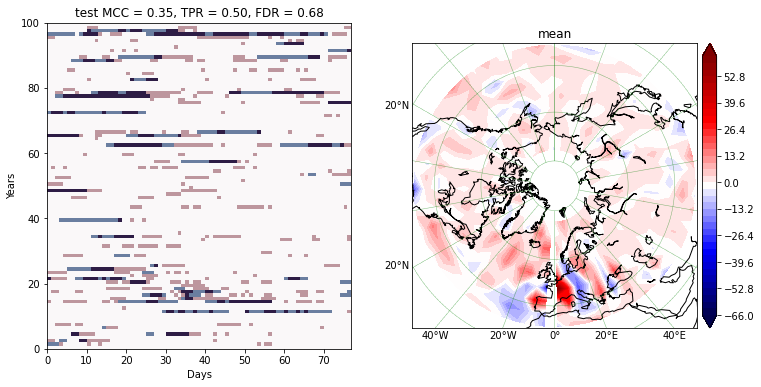

In [27]:
plt.rcParams['pcolor.shading'] ='flat'

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.pcolormesh(np.array(Y_test).reshape(100,-1), cmap=plt.cm.Blues)
plt.pcolormesh(np.array(logreg[i].predict(X_test)).reshape(100,-1), cmap=plt.cm.Reds,alpha=0.4)
plt.title(Xname+f' MCC = {Tot_MCC[9]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}')
plt.xlabel('Days')
plt.ylabel('Years')
#fig.savefig('Logistic/timelog_'+Xname+'.png')

import itertools

coef_breaks = list(itertools.accumulate([0]+[myXs.shape[1] for myXs in Xs]))
print(coef_breaks, lat_to, j, len(lat_to))
logregcoef  = []
logregcoef_std = []
logregcoef_mean_over_std = []
for j in range(len(lat_to)):
    print(j)
    logregcoef_value = np.zeros((10,lat_to[j]-lat_from[j],lon_to[j]-lon_from[j]))
    print(logregcoef_value.shape,coef_breaks[j],coef_breaks[j+1])
    for i in range(10):
        #print("logreg[i].coef_.shape = ", logreg[i].coef_.shape)
        #print("logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].shape = ", logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].shape)
        logregcoef_value[i,:,:] += logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].reshape((lat_to[j]-lat_from[j],lon_to[j]-lon_from[j]), order='F')

    logregcoef.append(np.mean(logregcoef_value,0))
    logregcoef_std.append(np.std(logregcoef_value,0))
    logregcoef_mean_over_std.append((lambda a, b: np.divide(a, b, out=np.zeros(a.shape), where=b != 0))(logregcoef[j], logregcoef_std[j]))


    print("[np.max(logregcoef),-np.min(logregcoef)] = ",[np.max(logregcoef[j]),-np.min(logregcoef[j])])

for mylogregcoef, myname in zip([logregcoef],["mean"]): #, logregcoef_std, logregcoef_mean_over_std],["mean","std","mean_over_std"]):
    ax = plt.subplot(122)
    m = Basemap(projection='nplaea',boundinglat=30,lon_0=0,resolution='c')
    npmax = 0
    npmin = 0
    coef_levels_max = np.max([np.max(mymylogregcoef) for mymylogregcoef in mylogregcoef]+[np.min(mymylogregcoef) for mymylogregcoef in mylogregcoef] ) 
    print("coef_levels_max = ", coef_levels_max)
    #coef_levels_max = np.max([np.max(mylogregcoef[0]),-np.min(mylogregcoef[0]),np.max(mylogregcoef[1]),-np.min(mylogregcoef[1])])/2
    
    if myname == "mean_over_std":
        coef_levels = np.arange(-10,10,10/20)
    else:
        coef_levels = np.arange(-coef_levels_max,coef_levels_max,(coef_levels_max/20))
    for j in range(len(lon_from)):
        m.contourf((LON_2by2[lat_from[j]:lat_to[j],lon_from[j]:lon_to[j]]), (LAT_2by2[lat_from[j]:lat_to[j],lon_from[j]:lon_to[j]]), (mylogregcoef[j]), coef_levels, cmap="seismic", extend='both', latlon=True)
    m.colorbar()
    m.drawcoastlines(color='black',linewidth=1)
    m.drawparallels(np.arange(-80.,81.,20.),linewidth=0.5,labels=[True,False,False,False], color = "green")
    m.drawmeridians(np.arange(-180.,181.,20.),linewidth=0.5,labels=[False,False,False,True],color = "green")
    plt.title(myname)
    #fig.savefig("Logistic/coef_"+myname+"_"+Xname[9:-4]+".png")

plt.show()

In [34]:
%%time

lat_from = [5//2, 5//2] #[13]  #[10, 10, 5]   #lat_from = [5,  5]
lat_to =  [22//2, 22//2] #[17]  #[16, 16, 22]   #lat_to =   [22, 22]
lon_from = [0//2,  110//2] #[0]  #[-1, 0, 108] #lon_from = [0,  100]
lon_to =   [15//2, 128//2] #[128] #[0, 7, 120]  #lon_to =   [15, 128]


thefield = 't2m'
solver_loss = 'hinge' # 'liblinear' #'sag' #'liblinear'
mypenalty = 'l1' #'l2'
cost = 1e-3 # 1e5 #1e6 #1e5

max_iterations = 1e4 #3e2 #5e3 # 3e2
undersampling_factor = 5

print([percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost])
def CallRegression(): # Here we specify what kind of regression we will call
    #return LogisticRegression(solver='liblinear',C=cost, max_iter=2e2)#,max_iter=1e4,C=1e5)
    #return LogisticRegression(solver=solver_loss,C=cost, penalty=mypenalty, max_iter=max_iterations)
    return linear_model.SGDClassifier(loss=solver_loss, penalty=mypenalty, alpha=cost, max_iter=max_iterations)
Xname = 'test'

def Grid_ReshapeInto2Dseries(myfield,time_start,time_end,lat_from,lat_to,lon_from,lon_to,T,tau):
    temp = myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].reshape((myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[0]*myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[1],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[2],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[3])) # Normal order in python is that of C (first index changes first)
    return temp.reshape((temp.shape[0],temp.shape[1]*temp.shape[2]), order='F') # Fortran order (last index changes first)

Xs = [Grid_ReshapeInto2Dseries(t2m_2by2,Tot_Mon1[6], Tot_Mon1[9],lat_from1,lat_to1,lon_from1,lon_to1,T,0) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)]
X = np.concatenate(Xs, axis=1)
print("X.shape = ", X.shape) # do the previous statement in steps so that first we get a list (I extract the necessary sizes)


labels = list_extremes
Tot_MCC = np.zeros(10,)
logreg = []
for j in range(2):
    for k in range(5):
        i = 5*j + k
        #X = zg500.var_reshaped
        #X = np.c_[Xs[0],Xs[1]]
        X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, undersampling_factor,'False')# Split the data into training/testing sets)
        logreg.append(CallRegression())
        logreg[i].fit(X_train_new, Y_train_new)
        Y_pred = logreg[i].predict(X_test) # confusion matrix works despite the fact that Y_test is True/False and Y_pred is 1/0
        TP, TN, FP, FN, Tot_MCC[i] = ComputeMCC(Y_test, Y_pred, 'True')
        filename = 'Postproc/Model_'+Xname+'_i'+str(i)+'.sav'
        #pickle.dump([logreg[i], percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost], open(filename, 'wb'))
        print(f"MCC {Tot_MCC[i]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}")
print("MCC = ", np.mean(Tot_MCC), " +- ", np.std(Tot_MCC))

[5, 14, 'Plasim', 'France', 5, [2, 2], [11, 11], [0, 55], [7, 64], 't2m', 'hinge', 'l1', 0.001]
X.shape =  (77000, 144)
i:  0  , X_train.shape =  (69300, 144) , X_test.shape =  (7700, 144)  , a =  0  , b =  7700
Y_train positives =  3587 Y_train negatives =  65713  , Y_test positives =  262  , Y_test negatives =  7438
Y_train positives =  3587 Y_train negatives =  13142
MCC =  0.3289488347036778  , TP =  131  , TN =  7063  , FP =  375  , FN =  131
MCC 0.33, TPR = 0.50, FDR = 0.74
i:  1  , X_train.shape =  (69300, 144) , X_test.shape =  (7700, 144)  , a =  7700  , b =  15400
Y_train positives =  3427 Y_train negatives =  65873  , Y_test positives =  422  , Y_test negatives =  7278
Y_train positives =  3427 Y_train negatives =  13174
MCC =  0.39562569873544484  , TP =  228  , TN =  6858  , FP =  420  , FN =  194
MCC 0.40, TPR = 0.54, FDR = 0.65
i:  2  , X_train.shape =  (69300, 144) , X_test.shape =  (7700, 144)  , a =  15400  , b =  23100
Y_train positives =  3460 Y_train negatives =  6

[0, 63, 144] [11, 11] 1 2
0
(10, 9, 7) 0 63
[np.max(logregcoef),-np.min(logregcoef)] =  [3.66316007238816, 1.1733349613408934]
1
(10, 9, 9) 63 144
[np.max(logregcoef),-np.min(logregcoef)] =  [4.081329449566291, 3.7502504224153816]
coef_levels_max =  4.081329449566291


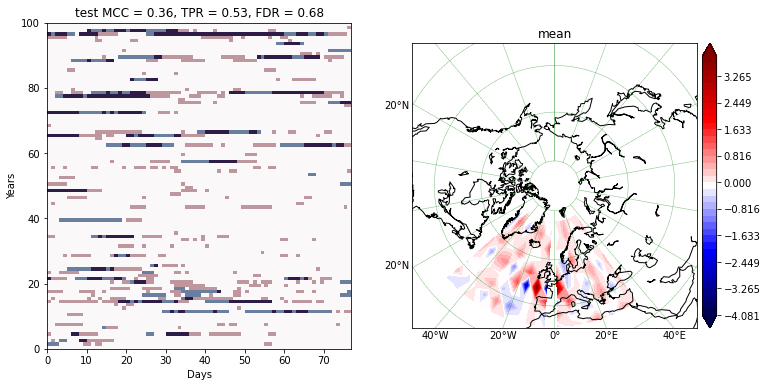

In [35]:
plt.rcParams['pcolor.shading'] ='flat'

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.pcolormesh(np.array(Y_test).reshape(100,-1), cmap=plt.cm.Blues)
plt.pcolormesh(np.array(logreg[i].predict(X_test)).reshape(100,-1), cmap=plt.cm.Reds,alpha=0.4)
plt.title(Xname+f' MCC = {Tot_MCC[9]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}')
plt.xlabel('Days')
plt.ylabel('Years')
#fig.savefig('Logistic/timelog_'+Xname+'.png')

import itertools

coef_breaks = list(itertools.accumulate([0]+[myXs.shape[1] for myXs in Xs]))
print(coef_breaks, lat_to, j, len(lat_to))
logregcoef  = []
logregcoef_std = []
logregcoef_mean_over_std = []
for j in range(len(lat_to)):
    print(j)
    logregcoef_value = np.zeros((10,lat_to[j]-lat_from[j],lon_to[j]-lon_from[j]))
    print(logregcoef_value.shape,coef_breaks[j],coef_breaks[j+1])
    for i in range(10):
        #print("logreg[i].coef_.shape = ", logreg[i].coef_.shape)
        #print("logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].shape = ", logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].shape)
        logregcoef_value[i,:,:] += logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].reshape((lat_to[j]-lat_from[j],lon_to[j]-lon_from[j]), order='F')

    logregcoef.append(np.mean(logregcoef_value,0))
    logregcoef_std.append(np.std(logregcoef_value,0))
    logregcoef_mean_over_std.append((lambda a, b: np.divide(a, b, out=np.zeros(a.shape), where=b != 0))(logregcoef[j], logregcoef_std[j]))


    print("[np.max(logregcoef),-np.min(logregcoef)] = ",[np.max(logregcoef[j]),-np.min(logregcoef[j])])

for mylogregcoef, myname in zip([logregcoef],["mean"]): #, logregcoef_std, logregcoef_mean_over_std],["mean","std","mean_over_std"]):
    ax = plt.subplot(122)
    m = Basemap(projection='nplaea',boundinglat=30,lon_0=0,resolution='c')
    npmax = 0
    npmin = 0
    coef_levels_max = np.max([np.max(mymylogregcoef) for mymylogregcoef in mylogregcoef]+[np.min(mymylogregcoef) for mymylogregcoef in mylogregcoef] ) 
    print("coef_levels_max = ", coef_levels_max)
    #coef_levels_max = np.max([np.max(mylogregcoef[0]),-np.min(mylogregcoef[0]),np.max(mylogregcoef[1]),-np.min(mylogregcoef[1])])/2
    
    if myname == "mean_over_std":
        coef_levels = np.arange(-10,10,10/20)
    else:
        coef_levels = np.arange(-coef_levels_max,coef_levels_max,(coef_levels_max/20))
    for j in range(len(lon_from)):
        m.contourf((LON_2by2[lat_from[j]:lat_to[j],lon_from[j]:lon_to[j]]), (LAT_2by2[lat_from[j]:lat_to[j],lon_from[j]:lon_to[j]]), (mylogregcoef[j]), coef_levels, cmap="seismic", extend='both', latlon=True)
    m.colorbar()
    m.drawcoastlines(color='black',linewidth=1)
    m.drawparallels(np.arange(-80.,81.,20.),linewidth=0.5,labels=[True,False,False,False], color = "green")
    m.drawmeridians(np.arange(-180.,181.,20.),linewidth=0.5,labels=[False,False,False,True],color = "green")
    plt.title(myname)
    #fig.savefig("Logistic/coef_"+myname+"_"+Xname[9:-4]+".png")

plt.show()

In [36]:
%%time

lat_from = [5//2, 5//2] #[13]  #[10, 10, 5]   #lat_from = [5,  5]
lat_to =  [22//2, 22//2] #[17]  #[16, 16, 22]   #lat_to =   [22, 22]
lon_from = [0//2,  110//2] #[0]  #[-1, 0, 108] #lon_from = [0,  100]
lon_to =   [15//2, 128//2] #[128] #[0, 7, 120]  #lon_to =   [15, 128]


thefield = 't2m'
solver_loss = 'hinge' # 'liblinear' #'sag' #'liblinear'
mypenalty = 'l1' #'l2'
cost = 1e-3 # 1e5 #1e6 #1e5

max_iterations = 1e4 #3e2 #5e3 # 3e2
undersampling_factor = 5

print([percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost])
def CallRegression(): # Here we specify what kind of regression we will call
    #return LogisticRegression(solver='liblinear',C=cost, max_iter=2e2)#,max_iter=1e4,C=1e5)
    #return LogisticRegression(solver=solver_loss,C=cost, penalty=mypenalty, max_iter=max_iterations)
    return linear_model.SGDClassifier(loss=solver_loss, penalty=mypenalty, alpha=cost, max_iter=max_iterations)
Xname = 'test'

def Grid_ReshapeInto2Dseries(myfield,time_start,time_end,lat_from,lat_to,lon_from,lon_to,T,tau):
    temp = myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].reshape((myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[0]*myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[1],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[2],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[3])) # Normal order in python is that of C (first index changes first)
    return temp.reshape((temp.shape[0],temp.shape[1]*temp.shape[2]), order='F') # Fortran order (last index changes first)

Xs = [Grid_ReshapeInto2Dseries(zg500_2by2,Tot_Mon1[6], Tot_Mon1[9],lat_from1,lat_to1,lon_from1,lon_to1,T,0) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)]
X = np.concatenate(Xs, axis=1)
print("X.shape = ", X.shape) # do the previous statement in steps so that first we get a list (I extract the necessary sizes)


labels = list_extremes
Tot_MCC = np.zeros(10,)
logreg = []
for j in range(2):
    for k in range(5):
        i = 5*j + k
        #X = zg500.var_reshaped
        #X = np.c_[Xs[0],Xs[1]]
        X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, undersampling_factor,'False')# Split the data into training/testing sets)
        logreg.append(CallRegression())
        logreg[i].fit(X_train_new, Y_train_new)
        Y_pred = logreg[i].predict(X_test) # confusion matrix works despite the fact that Y_test is True/False and Y_pred is 1/0
        TP, TN, FP, FN, Tot_MCC[i] = ComputeMCC(Y_test, Y_pred, 'True')
        filename = 'Postproc/Model_'+Xname+'_i'+str(i)+'.sav'
        #pickle.dump([logreg[i], percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost], open(filename, 'wb'))
        print(f"MCC {Tot_MCC[i]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}")
print("MCC = ", np.mean(Tot_MCC), " +- ", np.std(Tot_MCC))

[5, 14, 'Plasim', 'France', 5, [2, 2], [11, 11], [0, 55], [7, 64], 't2m', 'hinge', 'l1', 0.001]
X.shape =  (77000, 144)
i:  0  , X_train.shape =  (69300, 144) , X_test.shape =  (7700, 144)  , a =  0  , b =  7700
Y_train positives =  3587 Y_train negatives =  65713  , Y_test positives =  262  , Y_test negatives =  7438
Y_train positives =  3587 Y_train negatives =  13142
MCC =  0.20997900547516324  , TP =  97  , TN =  6956  , FP =  482  , FN =  165
MCC 0.21, TPR = 0.37, FDR = 0.83
i:  1  , X_train.shape =  (69300, 144) , X_test.shape =  (7700, 144)  , a =  7700  , b =  15400
Y_train positives =  3427 Y_train negatives =  65873  , Y_test positives =  422  , Y_test negatives =  7278
Y_train positives =  3427 Y_train negatives =  13174
MCC =  0.2421824406031013  , TP =  192  , TN =  6517  , FP =  761  , FN =  230
MCC 0.24, TPR = 0.45, FDR = 0.80
i:  2  , X_train.shape =  (69300, 144) , X_test.shape =  (7700, 144)  , a =  15400  , b =  23100
Y_train positives =  3460 Y_train negatives =  65

[0, 63, 144] [11, 11] 1 2
0
(10, 9, 7) 0 63
[np.max(logregcoef),-np.min(logregcoef)] =  [51.23324089459082, 48.57728603982681]
1
(10, 9, 9) 63 144
[np.max(logregcoef),-np.min(logregcoef)] =  [43.04056768525112, 39.10063933598089]
coef_levels_max =  51.23324089459082


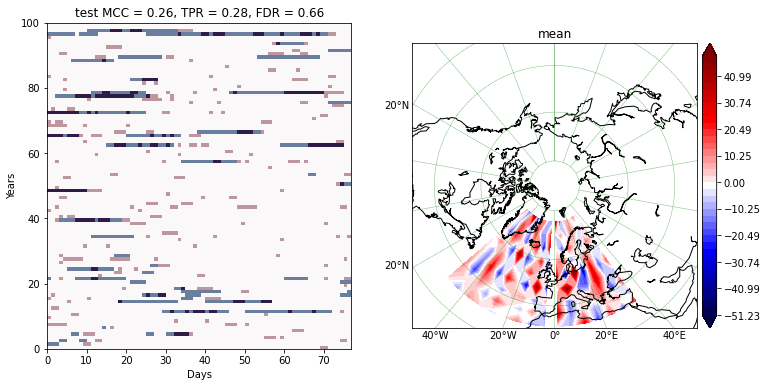

In [37]:
plt.rcParams['pcolor.shading'] ='flat'

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.pcolormesh(np.array(Y_test).reshape(100,-1), cmap=plt.cm.Blues)
plt.pcolormesh(np.array(logreg[i].predict(X_test)).reshape(100,-1), cmap=plt.cm.Reds,alpha=0.4)
plt.title(Xname+f' MCC = {Tot_MCC[9]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}')
plt.xlabel('Days')
plt.ylabel('Years')
#fig.savefig('Logistic/timelog_'+Xname+'.png')

import itertools

coef_breaks = list(itertools.accumulate([0]+[myXs.shape[1] for myXs in Xs]))
print(coef_breaks, lat_to, j, len(lat_to))
logregcoef  = []
logregcoef_std = []
logregcoef_mean_over_std = []
for j in range(len(lat_to)):
    print(j)
    logregcoef_value = np.zeros((10,lat_to[j]-lat_from[j],lon_to[j]-lon_from[j]))
    print(logregcoef_value.shape,coef_breaks[j],coef_breaks[j+1])
    for i in range(10):
        #print("logreg[i].coef_.shape = ", logreg[i].coef_.shape)
        #print("logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].shape = ", logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].shape)
        logregcoef_value[i,:,:] += logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].reshape((lat_to[j]-lat_from[j],lon_to[j]-lon_from[j]), order='F')

    logregcoef.append(np.mean(logregcoef_value,0))
    logregcoef_std.append(np.std(logregcoef_value,0))
    logregcoef_mean_over_std.append((lambda a, b: np.divide(a, b, out=np.zeros(a.shape), where=b != 0))(logregcoef[j], logregcoef_std[j]))


    print("[np.max(logregcoef),-np.min(logregcoef)] = ",[np.max(logregcoef[j]),-np.min(logregcoef[j])])

for mylogregcoef, myname in zip([logregcoef],["mean"]): #, logregcoef_std, logregcoef_mean_over_std],["mean","std","mean_over_std"]):
    ax = plt.subplot(122)
    m = Basemap(projection='nplaea',boundinglat=30,lon_0=0,resolution='c')
    npmax = 0
    npmin = 0
    coef_levels_max = np.max([np.max(mymylogregcoef) for mymylogregcoef in mylogregcoef]+[np.min(mymylogregcoef) for mymylogregcoef in mylogregcoef] ) 
    print("coef_levels_max = ", coef_levels_max)
    #coef_levels_max = np.max([np.max(mylogregcoef[0]),-np.min(mylogregcoef[0]),np.max(mylogregcoef[1]),-np.min(mylogregcoef[1])])/2
    
    if myname == "mean_over_std":
        coef_levels = np.arange(-10,10,10/20)
    else:
        coef_levels = np.arange(-coef_levels_max,coef_levels_max,(coef_levels_max/20))
    for j in range(len(lon_from)):
        m.contourf((LON_2by2[lat_from[j]:lat_to[j],lon_from[j]:lon_to[j]]), (LAT_2by2[lat_from[j]:lat_to[j],lon_from[j]:lon_to[j]]), (mylogregcoef[j]), coef_levels, cmap="seismic", extend='both', latlon=True)
    m.colorbar()
    m.drawcoastlines(color='black',linewidth=1)
    m.drawparallels(np.arange(-80.,81.,20.),linewidth=0.5,labels=[True,False,False,False], color = "green")
    m.drawmeridians(np.arange(-180.,181.,20.),linewidth=0.5,labels=[False,False,False,True],color = "green")
    plt.title(myname)
    #fig.savefig("Logistic/coef_"+myname+"_"+Xname[9:-4]+".png")

plt.show()

In [42]:
%%time

lat_from = [5//2, 5//2] #[13]  #[10, 10, 5]   #lat_from = [5,  5]
lat_to =  [22//2, 22//2] #[17]  #[16, 16, 22]   #lat_to =   [22, 22]
lon_from = [0//2,  100//2] #[0]  #[-1, 0, 108] #lon_from = [0,  100]
lon_to =   [15//2, 128//2] #[128] #[0, 7, 120]  #lon_to =   [15, 128]


thefield = 't2m'
solver_loss = 'hinge' # 'liblinear' #'sag' #'liblinear'
mypenalty = 'l1' #'l2'
cost = 1e-3 # 1e5 #1e6 #1e5

max_iterations = 1e4 #3e2 #5e3 # 3e2
undersampling_factor = 5

print([percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost])
def CallRegression(): # Here we specify what kind of regression we will call
    #return LogisticRegression(solver='liblinear',C=cost, max_iter=2e2)#,max_iter=1e4,C=1e5)
    #return LogisticRegression(solver=solver_loss,C=cost, penalty=mypenalty, max_iter=max_iterations)
    return linear_model.SGDClassifier(loss=solver_loss, penalty=mypenalty, alpha=cost, max_iter=max_iterations)
Xname = 'test'

def Grid_ReshapeInto2Dseries(myfield,time_start,time_end,lat_from,lat_to,lon_from,lon_to,T,tau):
    temp = myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].reshape((myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[0]*myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[1],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[2],myfield.var[:,(time_start+tau):(time_end+tau - T+1),lat_from:lat_to,lon_from:lon_to].shape[3])) # Normal order in python is that of C (first index changes first)
    return temp.reshape((temp.shape[0],temp.shape[1]*temp.shape[2]), order='F') # Fortran order (last index changes first)
Xs = [Grid_ReshapeInto2Dseries(t2m_2by2,Tot_Mon1[6], Tot_Mon1[9],lat_from1,lat_to1,lon_from1,lon_to1,T,0) for lat_from1,lat_to1, lon_from1, lon_to1 in zip(lat_from,lat_to,lon_from,lon_to)]
X = np.c_[np.concatenate(Xs, axis=1),mrso.abs_area_int_reshape[:,np.newaxis]]

print("X.shape = ", X.shape) # do the previous statement in steps so that first we get a list (I extract the necessary sizes)


labels = list_extremes
Tot_MCC = np.zeros(10,)
logreg = []
for j in range(2):
    for k in range(5):
        i = 5*j + k
        #X = zg500.var_reshaped
        #X = np.c_[Xs[0],Xs[1]]
        X_train, X_test, Y_train, Y_test, X_train_new, Y_train_new = TrainTestSplit(i,X, labels, undersampling_factor,'False')# Split the data into training/testing sets)
        logreg.append(CallRegression())
        logreg[i].fit(X_train_new, Y_train_new)
        Y_pred = logreg[i].predict(X_test) # confusion matrix works despite the fact that Y_test is True/False and Y_pred is 1/0
        TP, TN, FP, FN, Tot_MCC[i] = ComputeMCC(Y_test, Y_pred, 'True')
        filename = 'Postproc/Model_'+Xname+'_i'+str(i)+'.sav'
        #pickle.dump([logreg[i], percent, T, Model, area, undersampling_factor, lat_from, lat_to, lon_from, lon_to, thefield, solver_loss, mypenalty, cost], open(filename, 'wb'))
        print(f"MCC {Tot_MCC[i]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}")
print("MCC = ", np.mean(Tot_MCC), " +- ", np.std(Tot_MCC))

[5, 14, 'Plasim', 'France', 5, [2, 2], [11, 11], [0, 50], [7, 64], 't2m', 'hinge', 'l1', 0.001]
X.shape =  (77000, 190)
i:  0  , X_train.shape =  (69300, 190) , X_test.shape =  (7700, 190)  , a =  0  , b =  7700
Y_train positives =  3587 Y_train negatives =  65713  , Y_test positives =  262  , Y_test negatives =  7438
Y_train positives =  3587 Y_train negatives =  13142
MCC =  0.3314603104676455  , TP =  124  , TN =  7111  , FP =  327  , FN =  138
MCC 0.33, TPR = 0.47, FDR = 0.73
i:  1  , X_train.shape =  (69300, 190) , X_test.shape =  (7700, 190)  , a =  7700  , b =  15400
Y_train positives =  3427 Y_train negatives =  65873  , Y_test positives =  422  , Y_test negatives =  7278
Y_train positives =  3427 Y_train negatives =  13174
MCC =  0.4231386058140825  , TP =  230  , TN =  6916  , FP =  362  , FN =  192
MCC 0.42, TPR = 0.55, FDR = 0.61
i:  2  , X_train.shape =  (69300, 190) , X_test.shape =  (7700, 190)  , a =  15400  , b =  23100
Y_train positives =  3460 Y_train negatives =  65

[0, 63, 189] [11, 11] 1 2
0
(10, 9, 7) 0 63
[np.max(logregcoef),-np.min(logregcoef)] =  [11.593609190729012, 3.7178452586657245]
1
(10, 9, 14) 63 189
[np.max(logregcoef),-np.min(logregcoef)] =  [6.80722208350721, 9.415626916122608]
coef_levels_max =  11.593609190729012


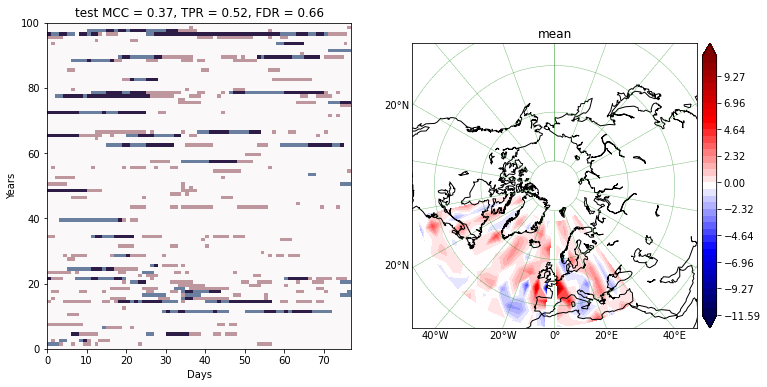

In [43]:
plt.rcParams['pcolor.shading'] ='flat'

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.pcolormesh(np.array(Y_test).reshape(100,-1), cmap=plt.cm.Blues)
plt.pcolormesh(np.array(logreg[i].predict(X_test)).reshape(100,-1), cmap=plt.cm.Reds,alpha=0.4)
plt.title(Xname+f' MCC = {Tot_MCC[9]:.2f}, TPR = {TP/(TP+FN):.2f}, FDR = {FP/(TP+FP):.2f}')
plt.xlabel('Days')
plt.ylabel('Years')
#fig.savefig('Logistic/timelog_'+Xname+'.png')

import itertools

coef_breaks = list(itertools.accumulate([0]+[myXs.shape[1] for myXs in Xs]))
print(coef_breaks, lat_to, j, len(lat_to))
logregcoef  = []
logregcoef_std = []
logregcoef_mean_over_std = []
for j in range(len(lat_to)):
    print(j)
    logregcoef_value = np.zeros((10,lat_to[j]-lat_from[j],lon_to[j]-lon_from[j]))
    print(logregcoef_value.shape,coef_breaks[j],coef_breaks[j+1])
    for i in range(10):
        #print("logreg[i].coef_.shape = ", logreg[i].coef_.shape)
        #print("logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].shape = ", logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].shape)
        logregcoef_value[i,:,:] += logreg[i].coef_[0,coef_breaks[j]:coef_breaks[j+1]].reshape((lat_to[j]-lat_from[j],lon_to[j]-lon_from[j]), order='F')

    logregcoef.append(np.mean(logregcoef_value,0))
    logregcoef_std.append(np.std(logregcoef_value,0))
    logregcoef_mean_over_std.append((lambda a, b: np.divide(a, b, out=np.zeros(a.shape), where=b != 0))(logregcoef[j], logregcoef_std[j]))


    print("[np.max(logregcoef),-np.min(logregcoef)] = ",[np.max(logregcoef[j]),-np.min(logregcoef[j])])

for mylogregcoef, myname in zip([logregcoef],["mean"]): #, logregcoef_std, logregcoef_mean_over_std],["mean","std","mean_over_std"]):
    ax = plt.subplot(122)
    m = Basemap(projection='nplaea',boundinglat=30,lon_0=0,resolution='c')
    npmax = 0
    npmin = 0
    coef_levels_max = np.max([np.max(mymylogregcoef) for mymylogregcoef in mylogregcoef]+[np.min(mymylogregcoef) for mymylogregcoef in mylogregcoef] ) 
    print("coef_levels_max = ", coef_levels_max)
    #coef_levels_max = np.max([np.max(mylogregcoef[0]),-np.min(mylogregcoef[0]),np.max(mylogregcoef[1]),-np.min(mylogregcoef[1])])/2
    
    if myname == "mean_over_std":
        coef_levels = np.arange(-10,10,10/20)
    else:
        coef_levels = np.arange(-coef_levels_max,coef_levels_max,(coef_levels_max/20))
    for j in range(len(lon_from)):
        m.contourf((LON_2by2[lat_from[j]:lat_to[j],lon_from[j]:lon_to[j]]), (LAT_2by2[lat_from[j]:lat_to[j],lon_from[j]:lon_to[j]]), (mylogregcoef[j]), coef_levels, cmap="seismic", extend='both', latlon=True)
    m.colorbar()
    m.drawcoastlines(color='black',linewidth=1)
    m.drawparallels(np.arange(-80.,81.,20.),linewidth=0.5,labels=[True,False,False,False], color = "green")
    m.drawmeridians(np.arange(-180.,181.,20.),linewidth=0.5,labels=[False,False,False,True],color = "green")
    plt.title(myname)
    #fig.savefig("Logistic/coef_"+myname+"_"+Xname[9:-4]+".png")

plt.show()